# An Exploration of Algorithmic Bias within COMPAS

## Preamble

### Imports

In [53]:
# !pip install scipy==1.6.0
# !pip install matplotlib==3.1.0
# !pip install plotly

In [1]:
import os, json, random
import numpy as np
import pandas as pd
import seaborn as sns
from plotly import graph_objects as go
from IPython.display import Markdown, display
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import spearmanr

In [2]:
# AIF360
import aif360
from aif360.datasets import CompasDataset
from aif360.sklearn.datasets import fetch_compas
# fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric, DatasetMetric
from aif360.metrics.common_utils import compute_metrics
from aif360.metrics.utils import compute_num_instances
# data preprocessing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas
# explainers
from aif360.explainers import MetricTextExplainer
# bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover, GerryFairClassifier
from aif360.sklearn.inprocessing import AdversarialDebiasing as SKLearnAdversarialDebiasing
from aif360.algorithms.inprocessing.gerryfair.clean import array_to_tuple
from aif360.algorithms.inprocessing.gerryfair.auditor import Auditor
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, RejectOptionClassification
from aif360.sklearn.utils import check_inputs, check_groups

In [3]:
# TensorFlow
import tensorflow
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [4]:
import sklearn
# scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree, linear_model
# metrics
from sklearn.metrics import accuracy_score, roc_curve, classification_report, confusion_matrix
# kernels
from sklearn.kernel_ridge import KernelRidge
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.datasets import make_blobs
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.inspection import permutation_importance

### Helper Functions

**Code reproductability**

In [5]:
np.random.seed(1)

**GitHub directories**

In [6]:
PLOTLY_FIGURES = '/Users/megantennies/FYP/plotly figures'
RESULTS = '/Users/megantennies/FYP/results'
DATA = '/Users/megantennies/FYP/saved data'

**Saving & loading data**

In [7]:
def save_to_json(filename, data):
    with open(os.path.join(DATA, filename), 'w') as write:
        json.dump(data, write)

def json_to_data(filename):
    with open(os.path.join(DATA, filename)) as file:
        data = json.load(file)
    df = pd.DataFrame(columns = data['columns'], data = data['data'])
    return df

def df_to_json(filename, df):
    df.to_json(os.path.join(DATA, filename), orient = 'split', 
    compression = 'infer', index = True)

def read_json(filename):
    with open(os.path.join(DATA, filename)) as file:
        data = json.load(file)
    return data

## Exploratory Data Analysis

### Moved

In [8]:
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]
original_dataset = load_preproc_data_compas(['race'])

In [9]:
default_mappings = {'label_maps': [{1.0: 'Recid', 0.0: 'Non-Recid'}], 
    'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}, 
    {1.0: 'White', 0.0: 'Non-White'}]}
metrics = ['Statistical parity difference', 'Average odds difference', 
    'Equal opportunity difference']

In [183]:
original_train, original_val, original_test = original_dataset.split([0.5, 0.8], shuffle = True)

In [184]:
def describe(train = None, val = None, test = None):
    if train is not None:
        display(Markdown('#### Training dataset shape'))
        print(train.features.shape)
    if val is not None:
        display(Markdown('#### Validation dataset shape'))
        print(val.features.shape)
    display(Markdown('#### Test dataset shape'))
    print(test.features.shape)
    display(Markdown('#### Favorable and unfavorable labels'))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown('#### Protected attribute names'))
    print(test.protected_attribute_names)
    display(Markdown('#### Privileged and unprivileged protected attribute values'))
    print(test.privileged_protected_attributes, test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(train.feature_names)

In [185]:
describe(original_train, original_val, original_test)

#### Training dataset shape

(2639, 10)


#### Validation dataset shape

(1583, 10)


#### Test dataset shape

(1056, 10)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['race']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


In [186]:
original_metric = BinaryLabelDatasetMetric(original_train, 
    unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)

In [187]:
original_explainer = MetricTextExplainer(original_metric)
display(Markdown('#### Original COMPAS training data'))

original_train_metric = BinaryLabelDatasetMetric(original_train, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Training data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_train_metric.mean_difference())

original_val_metric = BinaryLabelDatasetMetric(original_val, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Validation data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_val_metric.mean_difference())

original_test_metric = BinaryLabelDatasetMetric(original_test, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Testing data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_test_metric.mean_difference())

#### Original COMPAS training data

Training data: Difference in mean outcomes between unprivileged and privileged groups = -0.140946
Validation data: Difference in mean outcomes between unprivileged and privileged groups = -0.122756
Testing data: Difference in mean outcomes between unprivileged and privileged groups = -0.123801


### Dataset Analysis

In [15]:
dataset = '/Users/megantennies/FYP/data/compas-scores-two-years.csv'
compas_data = pd.read_csv(dataset)
compas_data = compas_data[['sex', 'age_cat', 'race', 'priors_count', 'c_charge_degree', 'two_year_recid']]
compas_data.head()

,sex,age_cat,race,priors_count,c_charge_degree,two_year_recid
0,Male,Greater than 45,Other,0,F,0
1,Male,25 - 45,African-American,0,F,1
2,Male,Less than 25,African-American,4,F,1
3,Male,Less than 25,African-American,1,F,0
4,Male,25 - 45,Other,2,F,0


In [95]:
def group_dataset(attribute):
    dataset = '/Users/megantennies/FYP/data/compas-scores-two-years.csv'
    df = pd.read_csv(dataset)
    df = df[[attribute, 'two_year_recid']]
    counts = df.groupby([attribute, 'two_year_recid']).size()
    df = pd.DataFrame(counts).reset_index()
    df = df.rename(columns = {attribute: attribute, 'two_year_recid': 'two_year_recid', 0: 'counts'})
    df = df.replace({0: 'No Recidivism', 1: 'Recidivism'})
    return df

In [114]:
def plot_counts(attribute, data, order, rename, xtitle, ytitle, legendloc, filename):
    plt.figure(figsize = (10, 8))
    ax = sns.barplot(x = attribute, y = 'counts', hue = 'two_year_recid', data = data, 
        palette = sns.color_palette('Greens'), 
        order = order)
    for val in ax.patches:
        ax.annotate(format(val.get_height(), '.0f'), (val.get_x() + \
            val.get_width() / 2., val.get_height()), ha = 'center', \
                va = 'center', xytext = (0, 9), textcoords = 'offset points')
    if rename == True:
        ax.set_xticklabels(['Felony', 'Misdemeanor'])
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    sns.set_style('whitegrid')
    plt.legend(title = 'Two-year Recidivism Score', loc = legendloc)
    plt.savefig(os.path.join(RESULTS, filename), bbox_inches = 'tight')

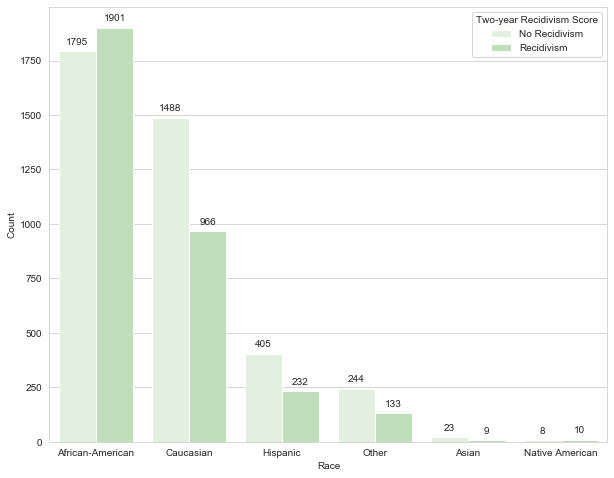

In [109]:
race_data = group_dataset(attribute = 'race')
plot_counts(attribute = 'race', data = race_data, xtitle = 'Race', ytitle = 'Count',
    order = ['African-American', 'Caucasian', 'Hispanic', 'Other', 'Asian', 'Native American'], 
    legendloc = 'upper right', filename = 'race_recid.png', rename = False)

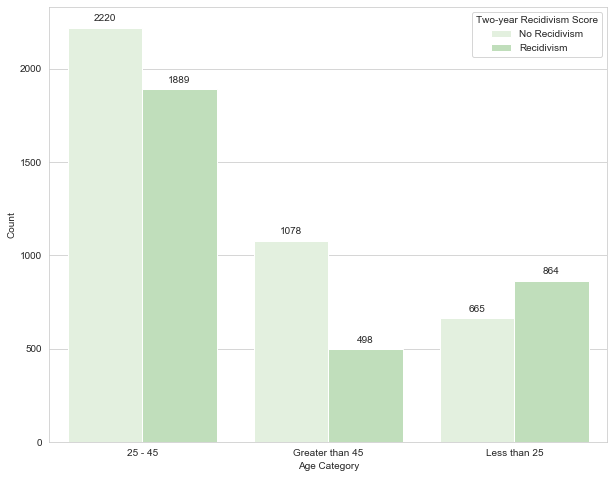

In [110]:
age_data = group_dataset(attribute = 'age_cat')
plot_counts(attribute = 'age_cat', data = age_data, xtitle = 'Age Category', ytitle = 'Count',
    order = ['25 - 45', 'Greater than 45', 'Less than 25'], rename = False,
    legendloc = 'upper right', filename = 'age_recid.png')

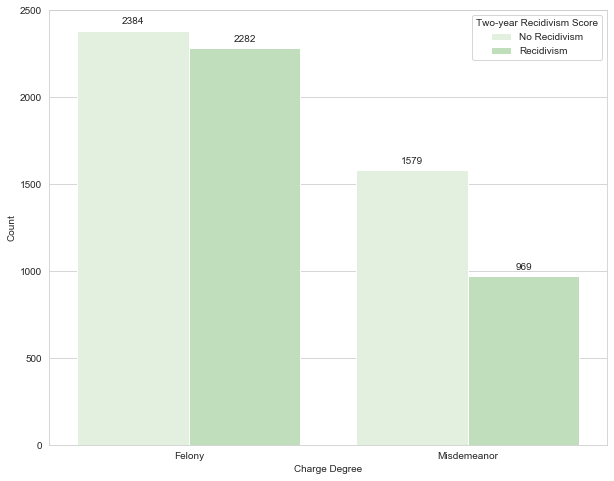

In [115]:
charge_data = group_dataset(attribute = 'c_charge_degree')
plot_counts(attribute = 'c_charge_degree', data = charge_data, xtitle = 'Charge Degree', 
    ytitle = 'Count', order = ['F', 'M'], rename = True,
    legendloc = 'upper right', filename = 'degree_recid.png')

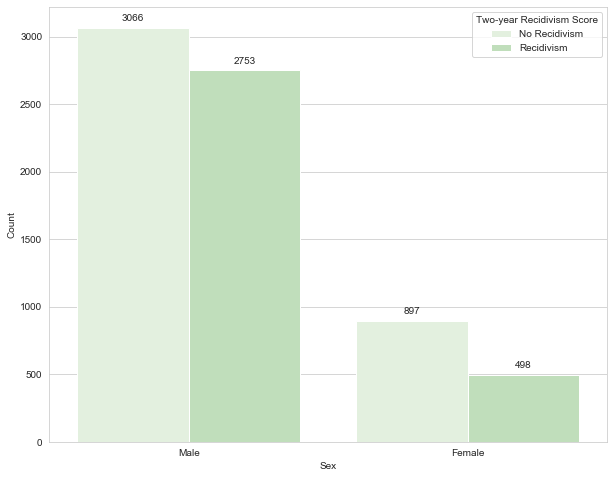

In [116]:
sex_data = group_dataset(attribute = 'sex')
plot_counts(attribute = 'sex', data = sex_data, xtitle = 'Sex', 
    ytitle = 'Count', order = ['Male', 'Female'], rename = False,
    legendloc = 'upper right', filename = 'sex_recid.png')

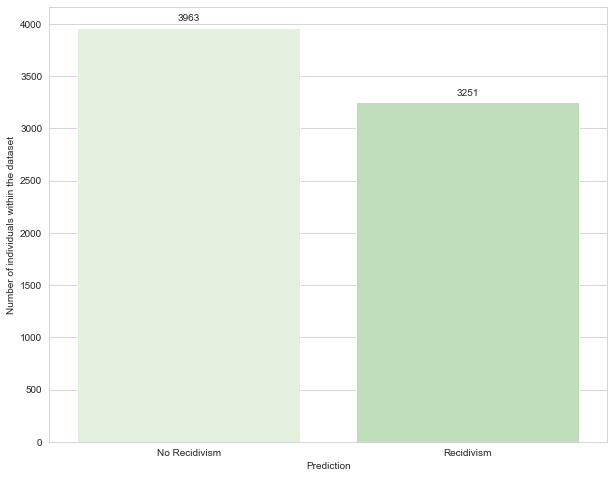

In [199]:
pred_counts = compas_data['two_year_recid'].value_counts()
plt.figure(figsize = (10, 8))
ax = sns.barplot(x = pred_counts.index, y = pred_counts.values, palette = sns.color_palette('Greens'))
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.0f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
ax.set_xticklabels(['No Recidivism', 'Recidivism'])
ax.set_xlabel('Prediction')
ax.set_ylabel('Number of individuals within the dataset')
sns.set_style('whitegrid')
plt.savefig(os.path.join(RESULTS, 'recid_nums.png'), bbox_inches = 'tight')

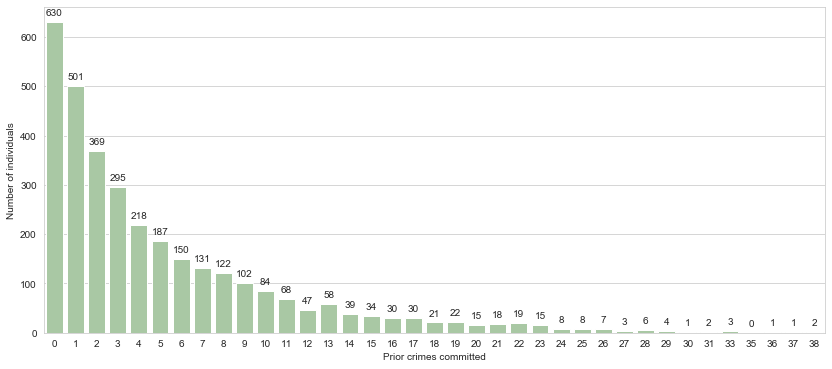

In [201]:
priors_nohue = compas_data[['priors_count', 'two_year_recid']]
priors_nohue = priors_nohue.groupby(['priors_count']).sum().reset_index()

plt.figure(figsize = (14,6))
ax = sns.barplot(x = 'priors_count', y = 'two_year_recid', data = priors_nohue, color = '#a4ce9e')
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.0f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
ax.set_xlabel('Prior crimes committed')
ax.set_ylabel('Number of individuals')
plt.savefig(os.path.join(RESULTS, 'priors_nohue.png'), bbox_inches = 'tight')

In [222]:
priors_data = compas_data[['priors_count', 'two_year_recid']]
counts = priors_data.groupby(['priors_count', 'two_year_recid']).size()
priors_data = pd.DataFrame(counts).reset_index()
priors_data = priors_data.rename(columns = {'priors_count': 'priors_count', 'two_year_recid': 'two_year_recid', 0: 'counts'})
priors_data['two_year_recid'] = priors_data['two_year_recid'].replace({0: 'No Recidivism', 1: 'Recidivism'})

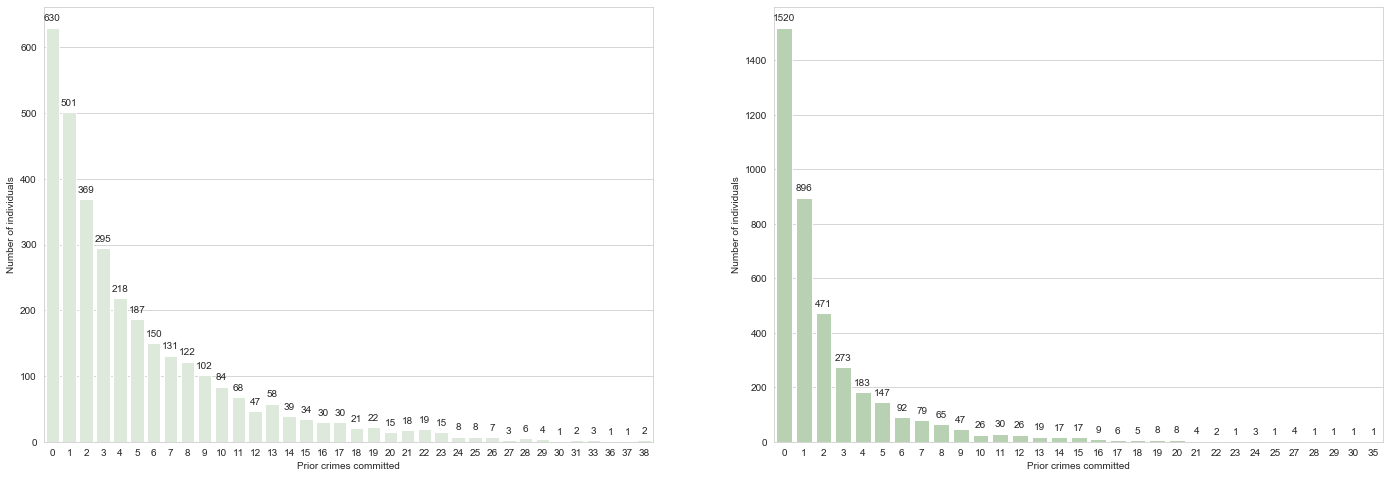

In [211]:
priors_recid = priors_data.loc[priors_data['two_year_recid'] == 'Recidivism']
priors_norecid = priors_data.loc[priors_data['two_year_recid'] == 'No Recidivism']

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (24, 8))
sns.barplot(x = 'priors_count', y = 'counts', data = priors_recid, color = '#dcecd7', ax = ax1)
for val in ax1.patches:
    ax1.annotate(format(val.get_height(), '.0f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
ax1.set_xlabel('Prior crimes committed')
ax1.set_ylabel('Number of individuals')

sns.barplot(x = 'priors_count', y = 'counts', data = priors_norecid, color = '#b3d6ad', ax = ax2)
for val in ax2.patches:
    ax2.annotate(format(val.get_height(), '.0f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
ax2.set_xlabel('Prior crimes committed')
ax2.set_ylabel('Number of individuals')
sns.set_style('whitegrid')
plt.savefig(os.path.join(RESULTS, 'priors_hue.png'), bbox_inches = 'tight')

### Spearman's Rank Co-efficient 

**Label Encoding: creating mappings for non-integer data**

In [24]:
race_dict = {'Caucasian': 1, 'African-American': 2, 'Hispanic': 3, 'Asian': 4, 'Native American': 5, 'Other': 6}
compas_data.race = [race_dict[item] for item in compas_data.race]

age_dict = {'Less than 25': 1, '25 - 45': 2, 'Greater than 45': 3}
compas_data.age_cat = [age_dict[item] for item in compas_data.age_cat]

gender_dict = {'Male': 1, 'Female': 0}
compas_data.sex = [gender_dict[item] for item in compas_data.sex]

charge_dict = {'M': 0, 'F': 1}
compas_data.c_charge_degree = [charge_dict[item] for item in compas_data.c_charge_degree]

In [26]:
compas_data.head()

,sex,age_cat,race,priors_count,c_charge_degree,two_year_recid
0,1,3,6,0,1,0
1,1,2,2,0,1,1
2,1,1,2,4,1,1
3,1,1,2,1,1,0
4,1,2,6,2,1,0


In [27]:
sex_arr = compas_data[['sex']].to_numpy()
age_arr = compas_data[['age_cat']].to_numpy()
race_arr = compas_data[['race']].to_numpy()
priors_arr = compas_data[['priors_count']].to_numpy()
charge_arr = compas_data[['c_charge_degree']].to_numpy()
label_arr = compas_data[['two_year_recid']].to_numpy()

In [42]:
def spearmans_rank(x_arr):
    alpha = 0.05
    coef, p = spearmanr(x_arr, label_arr)
    print('Spearmans Correlation Co-efficient: %.4f' % coef)
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0), p: %.4f' % p)
    else:
        print('Samples are correlated (reject H0), p: %.4f' % p)

In [43]:
spearmans_rank(x_arr = race_arr)

Spearmans Correlation Co-efficient: 0.0297
Samples are correlated (reject H0), p: 0.0117


In [44]:
spearmans_rank(x_arr = sex_arr)

Spearmans Correlation Co-efficient: 0.0922
Samples are correlated (reject H0), p: 0.0000


In [45]:
spearmans_rank(x_arr = age_arr)

Spearmans Correlation Co-efficient: -0.1645
Samples are correlated (reject H0), p: 0.0000


In [40]:
spearmans_rank(x_arr = priors_arr, attributename = 'Prior Offences')

Spearmans Correlation Co-efficient for Prior Offences: 0.29914764745770916
Samples are correlated (reject H0), p: 0.0000


In [41]:
spearmans_rank(x_arr = charge_arr, attributename = 'Charge Degree')

Spearmans Correlation Co-efficient for Charge Degree: 0.10448815266740921
Samples are correlated (reject H0), p: 0.0000


### K-means Clustering - Unsuccessful :(

In [46]:
compas_data.head()

,sex,age_cat,race,priors_count,c_charge_degree,two_year_recid
0,1,3,6,0,1,0
1,1,2,2,0,1,1
2,1,1,2,4,1,1
3,1,1,2,1,1,0
4,1,2,6,2,1,0


In [48]:
x = compas_data.iloc[:, [0, 1, 2, 3, 4]]
x = np.array(x)

**Finding optimal number of clusters**

In [59]:
distortions = []
K = range(1, 10)
for k in K:
    kmean_model = KMeans(n_clusters = k)
    kmean_model.fit(x)
    distortions.append(kmean_model.inertia_)

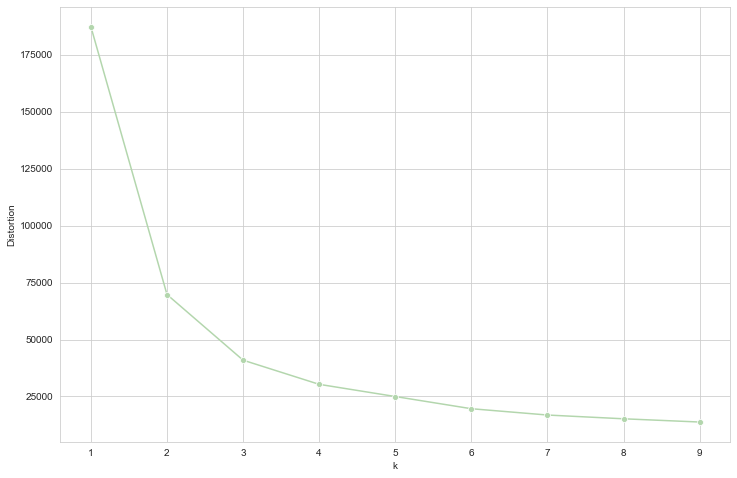

In [67]:
# elbow method to show optimal clusters
# optimal number = select value of k at the 'elbow' i.e. the point after which the distortion/inertia starts 
# decreasing in a linear fashion, so k=3
plt.figure(figsize = (12, 8))
sns.set_style('whitegrid')
ax = sns.lineplot(x = K, y = distortions, color = '#b3d6ad', marker = 'o')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.savefig(os.path.join(RESULTS, 'kmeans_clusters_elbow.png'), bbox_inches = 'tight')

**K-means Model**

In [72]:
kmeans = KMeans(n_clusters = 3, random_state = 32932)
kmeans_predict = kmeans.fit_predict(x)

In [73]:
compas_data['Cluster'] = kmeans_predict

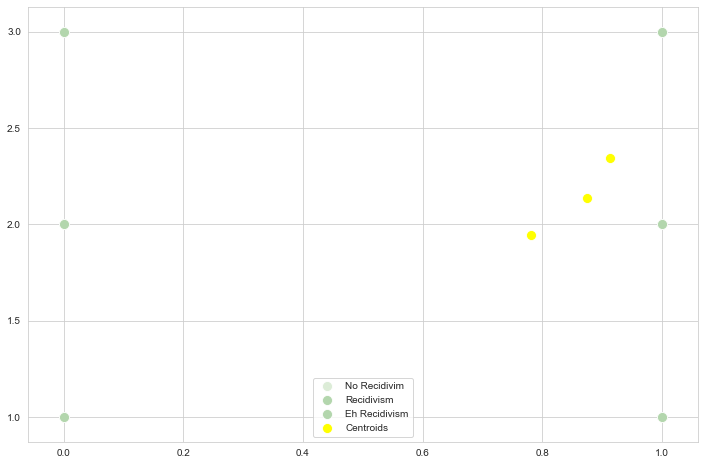

In [74]:
plt.figure(figsize = (12, 8))
sns.set_style('whitegrid')
ax = sns.scatterplot(x = x[kmeans_predict == 0, 0], y = x[kmeans_predict == 0, 1], s = 100, color = '#dcecd7', label = 'No Recidivim')
ax = sns.scatterplot(x = x[kmeans_predict == 1, 0], y = x[kmeans_predict == 1, 1], s = 100, color = '#b3d6ad', label = 'Recidivism')
ax = sns.scatterplot(x = x[kmeans_predict == 2, 0], y = x[kmeans_predict == 2, 1], s = 100, color = '#b3d6ad', label = 'Eh Recidivism')
ax = sns.scatterplot(x = kmeans.cluster_centers_[:, 0], y = kmeans.cluster_centers_[:,1], s = 100, color = 'yellow', label = 'Centroids')

# plt.savefig(os.path.join(RESULTS, 'kmeans_clustering.png'), bbox_inches = 'tight')

### Feature Importance

In [141]:
compas_data = compas_data[['sex', 'age_cat', 'race', 'priors_count', 'c_charge_degree', 'two_year_recid']]

object_data = compas_data[['age_cat', 'c_charge_degree', 'sex', 'race']]
encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
categoricals = ['age_cat', 'c_charge_degree', 'sex', 'race']
encoded_data = pd.DataFrame(encoder.fit_transform(compas_data[categoricals]))
encoded_data.columns = encoder.get_feature_names_out(categoricals)

int_data = compas_data.select_dtypes(include = 'int64').copy()
concat_data = pd.concat([encoded_data, int_data], axis = 1)
concat_data.head()

,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,c_charge_degree_F,c_charge_degree_M,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,priors_count,two_year_recid
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4,1
3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2,0


In [142]:
data_array = concat_data.to_numpy()
seed = np.random.seed(1)
features = ['age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'c_charge_degree_F', 'c_charge_degree_M', 'sex_Female', 'sex_Male', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other', 'priors_count']
X = data_array[:, 0:14]
y = data_array[:, 14]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

In [143]:
forest = RandomForestClassifier(random_state = 0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [144]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)

**MDI**

In [145]:
forest_importances_mdi = {'MDI_Feature': features, 'MDI_Importance': importances}
forest_importances_mdi = pd.DataFrame(data = forest_importances_mdi)

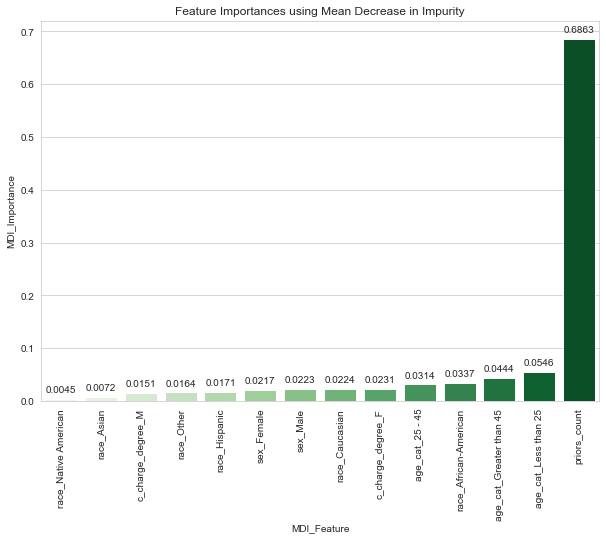

In [146]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(x = 'MDI_Feature', y = 'MDI_Importance', data = forest_importances_mdi, palette = 'Greens', 
    order = forest_importances_mdi.sort_values('MDI_Importance').MDI_Feature)
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
plt.title('Feature Importances using Mean Decrease in Impurity')
plt.xticks(rotation = 90)
plt.savefig('feat_import_MDI.png', bbox_inches = 'tight')

**FP**

In [147]:
feat_perm = permutation_importance(forest, X_test, y_test)

In [148]:
forest_importances_pi = {'FP_Feature': features, 'FP_Importance': feat_perm.importances_mean}
forest_importances_pi = pd.DataFrame(data = forest_importances_pi)

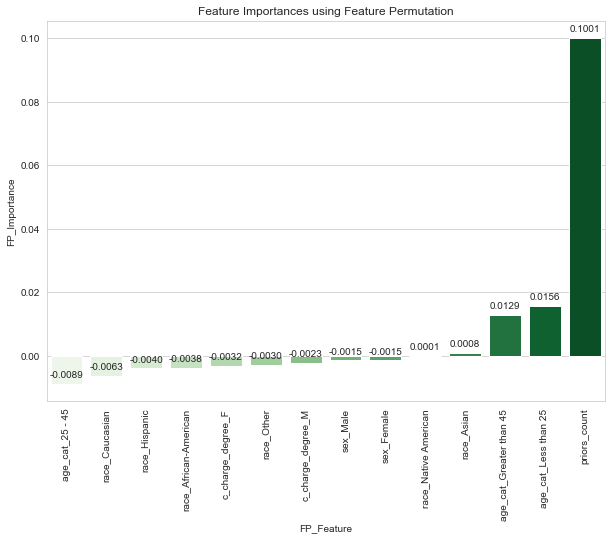

In [149]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(x = 'FP_Feature', y = 'FP_Importance', data = forest_importances_pi, palette = 'Greens', 
    order = forest_importances_pi.sort_values('FP_Importance').FP_Feature)
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
plt.title('Feature Importances using Feature Permutation')
plt.xticks(rotation = 90)
plt.savefig('feat_import_FP.png', bbox_inches = 'tight')

**Grouped**

In [193]:
forest_importances = pd.concat([forest_importances_mdi, forest_importances_pi], axis = 1)
forest_importances.drop(['FP_Feature'], axis = 1)

,MDI_Feature,MDI_Importance,FP_Importance
0,age_cat_25 - 45,0.031425,-0.008870
1,age_cat_Greater than 45,0.044375,0.012890
2,age_cat_Less than 25,0.054554,0.015593
3,c_charge_degree_F,0.023056,-0.003188
4,c_charge_degree_M,0.015126,-0.002287
5,sex_Female,0.021653,-0.001525
6,sex_Male,0.022305,-0.001525
7,race_African-American,0.033681,-0.003812
8,race_Asian,0.007168,0.000832
9,race_Caucasian,0.022390,-0.006306


In [194]:
age_cat_mdi = forest_importances.at[0, 'MDI_Importance'] + forest_importances.at[1, 'MDI_Importance'] \
    + forest_importances.at[2, 'MDI_Importance']
charge_degree_mdi = forest_importances.at[3, 'MDI_Importance'] + forest_importances.at[4, 'MDI_Importance']
sex_mdi = forest_importances.at[5, 'MDI_Importance'] + forest_importances.at[6, 'MDI_Importance']
race_mdi = forest_importances.at[7, 'MDI_Importance'] + forest_importances.at[8, 'MDI_Importance'] \
    + forest_importances.at[9, 'MDI_Importance'] + forest_importances.at[10, 'MDI_Importance'] \
    + forest_importances.at[11, 'MDI_Importance'] + forest_importances.at[12, 'MDI_Importance']
priors_mdi = forest_importances.at[13, 'MDI_Importance']

In [195]:
age_cat_fp = forest_importances.at[0, 'FP_Importance'] + forest_importances.at[1, 'FP_Importance'] \
    + forest_importances.at[2, 'FP_Importance']
charge_degree_fp = forest_importances.at[3, 'FP_Importance'] + forest_importances.at[4, 'FP_Importance']
sex_fp = forest_importances.at[5, 'FP_Importance'] + forest_importances.at[6, 'FP_Importance']
race_fp = forest_importances.at[7, 'FP_Importance'] + forest_importances.at[8, 'FP_Importance'] \
    + forest_importances.at[9, 'FP_Importance'] + forest_importances.at[10, 'FP_Importance'] \
    + forest_importances.at[11, 'FP_Importance'] + forest_importances.at[12, 'FP_Importance']
priors_fp = forest_importances.at[13, 'FP_Importance']

In [196]:
summative_importances = {'Feature': ['Age Category', 'Sex', 'Race', 'Charge Degree', 'Priors Count'],
    'Importance': [age_cat_mdi, sex_mdi, race_mdi, charge_degree_mdi, priors_mdi]}
summative_importances = pd.DataFrame(data = summative_importances)

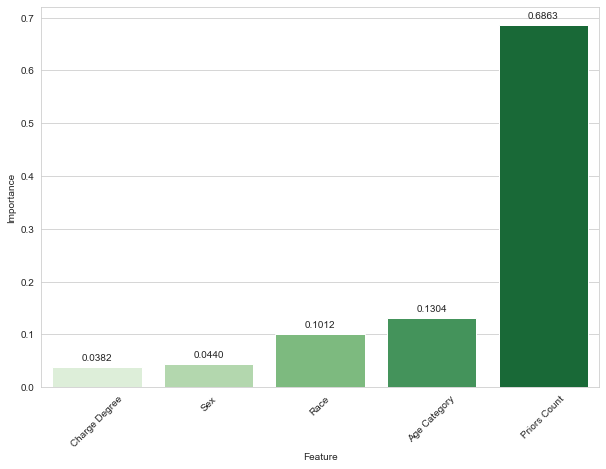

In [197]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(x = 'Feature', y = 'Importance', data = summative_importances, palette = 'Greens', 
    order = summative_importances.sort_values('Importance').Feature)
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
plt.xticks(rotation = 45)
plt.savefig('MDI_correct.png', bbox_inches = 'tight')

In [198]:
summative_importances = {'Feature': ['Age Category', 'Sex', 'Race', 'Charge Degree', 'Priors Count'],
    'Importance': [age_cat_fp, sex_fp, race_fp, charge_degree_fp, priors_fp]}
summative_importances = pd.DataFrame(data = summative_importances)

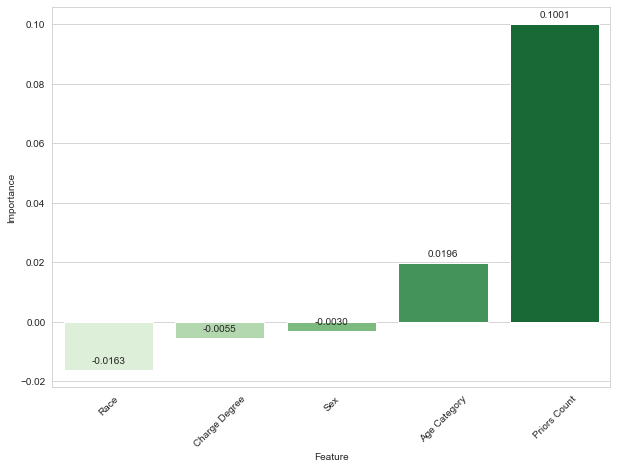

In [199]:
plt.figure(figsize = (10, 7))
ax = sns.barplot(x = 'Feature', y = 'Importance', data = summative_importances, palette = 'Greens', 
    order = summative_importances.sort_values('Importance').Feature)
for val in ax.patches:
    ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
sns.set_style('whitegrid')
plt.xticks(rotation = 45)
plt.savefig('FP_correct.png', bbox_inches = 'tight')

**Comparison**

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



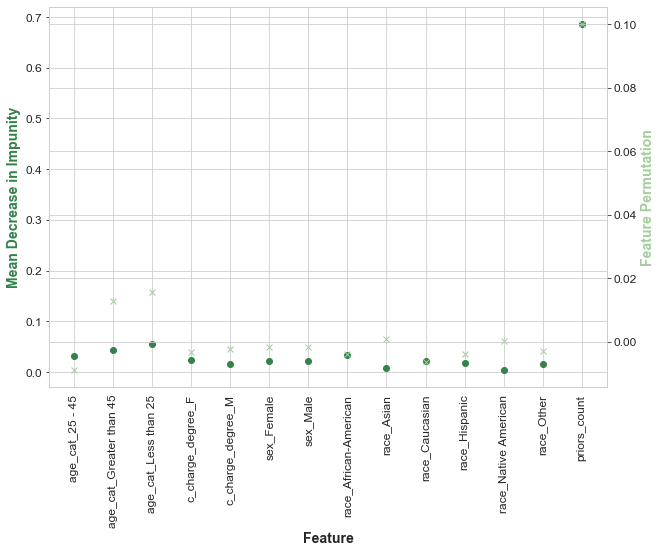

In [157]:
fig, ax1 = plt.subplots(figsize = (10, 7))
ax1.plot(forest_importances['MDI_Feature'], forest_importances['MDI_Importance'], color = '#348149', marker = 'o', linestyle = '')
ax1.set_xlabel('Feature', fontsize = 14, fontweight = 'bold')
ax1.set_ylabel('Mean Decrease in Impunity', color = '#348149', fontsize = 14, fontweight = 'bold')
ax1.xaxis.set_tick_params(labelsize = 12)
ax1.yaxis.set_tick_params(labelsize = 12)
ax1.set_xticklabels(forest_importances['MDI_Feature'], rotation = 90)

ax2 = ax1.twinx()
ax2.plot(forest_importances['MDI_Feature'], forest_importances['FP_Importance'], color = '#a4ce9e', marker = 'x', linestyle = '')
ax2.set_ylabel('Feature Permutation', color = '#a4ce9e', fontsize = 14, fontweight = 'bold')
ax2.yaxis.set_tick_params(labelsize = 12)
ax2.grid(True)
plt.savefig('feat_import_comp.png', bbox_inches = 'tight')

### Principal Component Analysis

In [158]:
list(concat_data.columns)

['age_cat_25 - 45',
 'age_cat_Greater than 45',
 'age_cat_Less than 25',
 'c_charge_degree_F',
 'c_charge_degree_M',
 'sex_Female',
 'sex_Male',
 'race_African-American',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Native American',
 'race_Other',
 'priors_count',
 'two_year_recid']

In [159]:
concat_data['two_year_recid'].replace(0, 'No Recid', inplace = True)
concat_data['two_year_recid'].replace(1, 'Recid', inplace = True)

x = concat_data.loc[:, concat_data.columns != 'two_year_recid'].values
x = StandardScaler().fit_transform(x)

In [160]:
# checking to see that the normalised data has a mean of 0 and standard deviation of 1
np.mean(x), np.std(x)

(-1.2804346499696843e-17, 1.0)

In [161]:
y = concat_data.iloc[:, -1:]
pca = PCA().fit(x)

Text(0, 0.5, 'Cumulative Explained Variance')

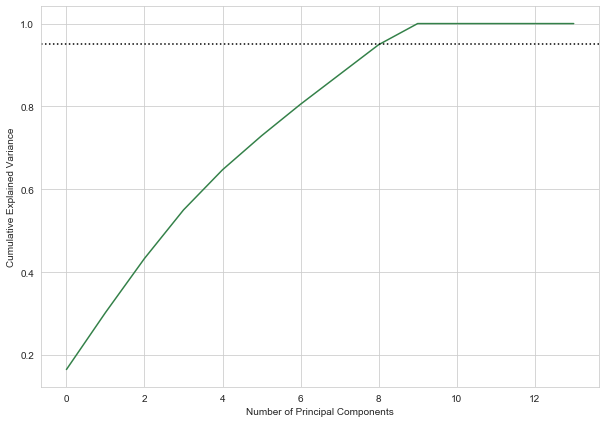

In [162]:
plt.figure(figsize = (10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color = '#348149')
plt.axhline(y = 0.95, linestyle = ':', color = 'black')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
# this curve quantifies how much of the total, 14-dimensional variance is contained within the first N components

In [163]:
pca = PCA(n_components = 2)
pca_comps = pca.fit_transform(x)
pca_data = pd.DataFrame(data = pca_comps, columns = ['principal_component_1', 'principal_component_2'])
pca_data['label'] = y
pca_data.head()

,principal_component_1,principal_component_2,label
0,-0.228954,-0.683274,No Recid
1,-1.552577,0.288087,Recid
2,-1.777270,0.365224,Recid
3,-1.627228,0.373161,No Recid
4,-0.808233,-0.192371,No Recid


In [164]:
print('Variation per principal component: {}'.format(pca.explained_variance_ratio_))
# principal component 1 holds 16.5% of the information, pc 2 holds 13.7% 
# ~70% of info was lost while projecting 14 dimensional data to 2 dimensional data

Variation per principal component: [0.16485817 0.13747641]


In [165]:
def draw_vector(v0, v1, ax = None):
    ax = ax or plt.gca()
    arrowprops = dict(arrowstyle = '->', linewidth = 2, shrinkA = 0, shrinkB = 0)
    ax.annotate('', v1, v0, arrowprops = arrowprops)

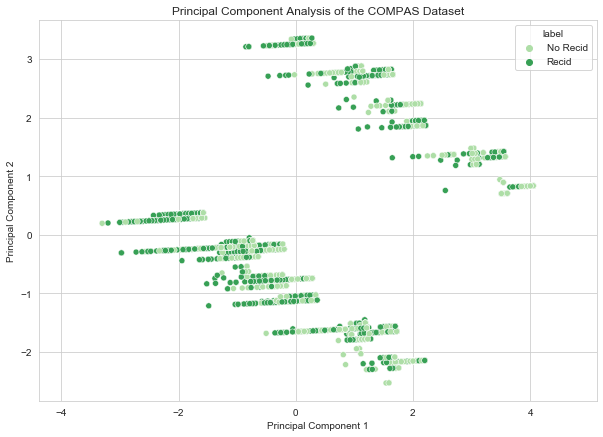

In [166]:
plt.figure(figsize = (10, 7))
ax = sns.scatterplot(x = 'principal_component_1', y = 'principal_component_2', hue = 'label',
    data = pca_data, legend = 'full', palette = sns.color_palette('Greens', 2))
sns.set_style('whitegrid')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.title('Principal Component Analysis of the COMPAS Dataset')
plt.axis('equal')
plt.savefig('pca_2', bbox_inches = 'tight')

In [168]:
compas_data.head()

,sex,age_cat,race,priors_count,c_charge_degree,two_year_recid
0,Male,Greater than 45,Other,0,F,0
1,Male,25 - 45,African-American,0,F,1
2,Male,Less than 25,African-American,4,F,1
3,Male,Less than 25,African-American,1,F,0
4,Male,25 - 45,Other,2,F,0


### Comparing Predictive Accuracy

True Positive (TP) is the number of instances in the dataset where both the predicted and actual labels are 'favorable', 
$$ TP = \sum_{i=1}^n \mathbb{1}[y_i = \text{favorable}]\mathbb{1}[\hat{y}_i = \text{favorable}] $$

False Positive (FP) is the number of instances in the dataset where the predicted label is 'favorable', but the actual label was 'unfavorable'
$$ FP = \sum_{i=1}^n \mathbb{1}[y_i = \text{unfavorable}]\mathbb{1}[\hat{y}_i = \text{favorable}] $$

False Negative (FN) is the number of instances in the dataset where the predicted label is 'unfavorable', but the actual label was 'favorable'
$$ FN = \sum_{i=1}^n \mathbb{1}[y_i = \text{favorable}]\mathbb{1}[\hat{y}_i = \text{unfavorable}] $$

True Negative (TN) is the number of instances in the dataset where both the predicted and actual labels are 'unfavorable', 
$$ TN = \sum_{i=1}^n \mathbb{1}[y_i = \text{unfavorable}]\mathbb{1}[\hat{y}_i = \text{unfavorable}] $$

**Data generation**

In [140]:
dataset = '/Users/megantennies/FYP/data/compas-scores-two-years.csv'
compas_data = pd.read_csv(dataset)
compas_data = compas_data[['sex', 'age_cat', 'race', 'priors_count', 'c_charge_degree', 'two_year_recid']]

**Encoding categorical data**

In [141]:
object_data = compas_data[['age_cat', 'c_charge_degree', 'sex', 'race']]
encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
categoricals = ['age_cat', 'c_charge_degree', 'sex', 'race']
encoded_data = pd.DataFrame(encoder.fit_transform(compas_data[categoricals]))
encoded_data.columns = encoder.get_feature_names_out(categoricals)

In [142]:
int_data = compas_data.select_dtypes(include = 'int64').copy()
concat_data = pd.concat([encoded_data, int_data], axis = 1)

**Fitting LR model**

In [146]:
data_array = concat_data.to_numpy()
seed = np.random.seed(1)
features = ['age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'c_charge_degree_F', 
    'c_charge_degree_M', 'sex_Female', 'sex_Male', 'race_African-American', 'race_Asian', 'race_Caucasian', 
    'race_Hispanic', 'race_Native American', 'race_Other', 'priors_count']
X = data_array[:, 0:14]
y = data_array[:, 14]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

In [149]:
LR = LogisticRegression()
LR.fit(X_train, y_train)
y_preds = LR.predict(X_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [151]:
recid_preds = LR.predict(X)
compas_data['prediction'] = recid_preds
compas_data.head()

,sex,age_cat,race,priors_count,c_charge_degree,two_year_recid,prediction
0,Male,Greater than 45,Other,0,F,0,0.0
1,Male,25 - 45,African-American,0,F,1,0.0
2,Male,Less than 25,African-American,4,F,1,1.0
3,Male,Less than 25,African-American,1,F,0,1.0
4,Male,25 - 45,Other,2,F,0,0.0


In [161]:
def confusion_metrics(actual, scores, threshold):
    y_predicted = scores.values
    y_true = actual.values
    TP = ((y_true == y_predicted) & (y_predicted == 1)).astype(int)
    FP = ((y_true != y_predicted) & (y_predicted == 1)).astype(int)
    TN = ((y_true == y_predicted) & (y_predicted == 0)).astype(int)
    FN = ((y_true != y_predicted) & (y_predicted == 0)).astype(int)
    return TP, FP, TN, FN

In [167]:
def calculate_impacts(data, sensitive_column, recid_col, score_col):
    if sensitive_column == 'race':
      norm_group = 'Caucasian'

    TP, FP, TN, FN = confusion_metrics(actual = data[recid_col], scores = data[score_col], threshold = 5.0)

    impact = pd.DataFrame(data = np.column_stack([FP, TP, FN, TN, data[sensitive_column].values, data[recid_col].values, data[score_col].values]),
        columns = ['FP', 'TP', 'FN', 'TN', 'sensitive', 'reoffend', 'score']).groupby(by = 'sensitive').agg({'reoffend': 'sum', \
            'score': 'sum', 'sensitive': 'count', 'FP': 'sum', 'TP': 'sum', 'FN': 'sum', 'TN': 'sum'}).rename(columns = {'sensitive': 'N'})

    impact['FPR'] = impact['FP'] / (impact['FP'] + impact['TN'])
    impact['FNR'] = impact['FN'] / (impact['FN'] + impact['TP'])
    impact['reoffend'] = impact['reoffend'] / impact['N']
    impact['score'] = impact['score'] / impact['N']
    impact['DFP'] = impact['FPR'] / impact.loc[norm_group, 'FPR']
    impact['DFN'] = impact['FNR'] / impact.loc[norm_group, 'FNR']
    return impact.drop(columns = ['FP', 'TP', 'FN', 'TN'])

In [168]:
impacts = calculate_impacts(data = compas_data, sensitive_column = 'race', recid_col = 'two_year_recid', score_col = 'prediction')

In [169]:
impacts.round(4)

,reoffend,score,N,FPR,FNR,DFP,DFN
sensitive,,,,,,,
African-American,0.5143,0.5076,3696,0.3415,0.3356,2.0741,0.5638
Asian,0.2812,0.0938,32,0.0435,0.7778,0.2641,1.3067
Caucasian,0.3936,0.2592,2454,0.1647,0.5952,1.0000,1.0000
Hispanic,0.3642,0.1915,637,0.1185,0.6810,0.7198,1.1441
Native American,0.5556,0.5556,18,0.1250,0.1000,0.7592,0.1680
Other,0.3528,0.1379,377,0.0738,0.7444,0.4480,1.2505


## Baseline Logistic Regression Model

**Data Loading**

In [57]:
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]
original_dataset = load_preproc_data_compas(['race'])

default_mappings = {'label_maps': [{1.0: 'Recid', 0.0: 'Non-Recid'}], 
    'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}, 
    {1.0: 'White', 0.0: 'Non-White'}]}
metrics = ['Statistical parity difference', 'Average odds difference', 
    'Equal opportunity difference']

original_train, original_val, original_test = original_dataset.split([0.5, 0.8], shuffle = True)

In [58]:
def describe(train = None, val = None, test = None):
    if train is not None:
        display(Markdown('#### Training dataset shape'))
        print(train.features.shape)
    if val is not None:
        display(Markdown('#### Validation dataset shape'))
        print(val.features.shape)
    display(Markdown('#### Test dataset shape'))
    print(test.features.shape)
    display(Markdown('#### Favorable and unfavorable labels'))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown('#### Protected attribute names'))
    print(test.protected_attribute_names)
    display(Markdown('#### Privileged and unprivileged protected attribute values'))
    print(test.privileged_protected_attributes, test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(train.feature_names)

In [59]:
describe(original_train, original_val, original_test)

#### Training dataset shape

(2639, 10)


#### Validation dataset shape

(1583, 10)


#### Test dataset shape

(1056, 10)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['race']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


In [60]:
original_metric = BinaryLabelDatasetMetric(original_train, 
    unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)

original_explainer = MetricTextExplainer(original_metric)
display(Markdown('#### Original COMPAS training data'))

original_train_metric = BinaryLabelDatasetMetric(original_train, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Training data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_train_metric.mean_difference())

original_val_metric = BinaryLabelDatasetMetric(original_val, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Validation data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_val_metric.mean_difference())

original_test_metric = BinaryLabelDatasetMetric(original_test, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print('Testing data: Difference in mean outcomes between unprivileged and privileged groups = %f' % original_test_metric.mean_difference())

#### Original COMPAS training data

Training data: Difference in mean outcomes between unprivileged and privileged groups = -0.150164
Validation data: Difference in mean outcomes between unprivileged and privileged groups = -0.129998
Testing data: Difference in mean outcomes between unprivileged and privileged groups = -0.091429


In [61]:
sens_ind = 0
sens_attr = original_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in original_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in original_train.privileged_protected_attributes[sens_ind]]

**Training LR model on the original COMPAS dataset**

In [62]:
original_scaler = StandardScaler()
X_train = original_scaler.fit_transform(original_train.features)
y_train = original_train.labels.ravel()
w_train = original_train.instance_weights.ravel()

In [63]:
lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train, sample_weight = original_train.instance_weights)
y_train_preds = lr.predict(X_train)

In [64]:
pos_ind = np.where(lr.classes_ == original_train.favorable_label)[0][0]

In [65]:
original_train_preds = original_train.copy()
original_train_preds.labels = y_train_preds

original_val_preds = original_val.copy(deepcopy = True)
X_val = original_scaler.transform(original_val_preds.features)
y_val = original_val_preds.labels
original_val_preds.scores = lr.predict_proba(X_val)[:, pos_ind].reshape(-1, 1)

original_test_preds = original_test.copy(deepcopy = True)
X_test = original_scaler.transform(original_test_preds.features)
y_test = original_test_preds.labels
original_test_preds.scores = lr.predict_proba(X_test)[:, pos_ind].reshape(-1, 1)

In [66]:
num_thresh = 100
bal_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    fav_inds = original_val_preds.scores > class_thresh
    original_val_preds.labels[fav_inds] = original_val_preds.favorable_label
    original_val_preds.labels[~fav_inds] = original_val_preds.unfavorable_label

    original_val_metric = ClassificationMetric(original_val, 
        original_val_preds, unprivileged_groups = unprivileged_groups, 
        privileged_groups = privileged_groups)

    bal_arr[idx] = 0.5 * (original_val_metric.true_positive_rate() 
        + original_val_metric.true_negative_rate())

In [67]:
best_ind = np.where(bal_arr == np.max(bal_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

display(Markdown('#### Original COMPAS data'))
print('Best balanced accuracy (no transforming): %.4f' % np.max(bal_arr))
print('Optimal classification threshold (no transforming): %.4f' % best_class_thresh)

#### Original COMPAS data

Best balanced accuracy (no transforming): 0.6583
Optimal classification threshold (no transforming): 0.4654


In [68]:
bal_acc_arr = []
disp_imp_arr = []
avg_odds_diff_arr = []
eq_opp_diff_arr = []
outcome_unfair_arr = []
acc_equal_arr = []

In [69]:
display(Markdown('#### Predictions from the original testing data'))
print('Classification threshold used: %.4f' % best_class_thresh)

for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    fav_inds = original_test_preds.scores > thresh
    original_test_preds.labels[fav_inds] = original_test_preds.favorable_label
    original_test_preds.labels[~fav_inds] = original_test_preds.unfavorable_label
    
    metric_test = compute_metrics(original_test, original_test_preds, \
        unprivileged_groups, privileged_groups, disp = disp)
    class_metric_test = ClassificationMetric(original_test, original_test_preds, \
        unprivileged_groups, privileged_groups)
    
    bal_acc_arr.append(metric_test['Balanced accuracy'])
    avg_odds_diff_arr.append(metric_test['Average odds difference'])
    disp_imp_arr.append(metric_test['Disparate impact'])
    eq_opp_diff_arr.append(metric_test['Equal opportunity difference'])
    outcome_unfair_arr.append(class_metric_test.false_discovery_rate_difference() \
        + class_metric_test.false_positive_rate_difference())
    acc_equal_arr.append((class_metric_test.true_positive_rate(privileged = True) + \
        class_metric_test.true_negative_rate(privileged = True)) - \
            (class_metric_test.true_positive_rate(privileged = False) + \
                class_metric_test.true_negative_rate(privileged = False)))

#### Predictions from the original testing data

Classification threshold used: 0.4654
Balanced accuracy = 0.6604
Statistical parity difference = -0.3166
Disparate impact = 0.6042
Average odds difference = -0.2934
Equal opportunity difference = -0.2562
Theil index = 0.1886




invalid value encountered in double_scalars


100%|██████████| 100/100 [00:00<00:00, 312.25it/s]


In [45]:
save_to_json(filename = 'LR_bal_acc_arr.json', data = bal_acc_arr)
save_to_json(filename = 'LR_disp_imp_arr.json', data = disp_imp_arr)
save_to_json(filename = 'LR_avg_odds_diff_arr.json', data = avg_odds_diff_arr)
save_to_json(filename = 'LR_eq_opp_diff_arr.json', data = eq_opp_diff_arr)
save_to_json(filename = 'LR_outcome_unfair_arr.json', data = outcome_unfair_arr)
save_to_json(filename = 'LR_acc_equal_arr.json', data = acc_equal_arr)

In [46]:
LR_bal_acc = np.interp(best_class_thresh, class_thresh_arr, bal_acc_arr)
LR_acc_equal = np.interp(best_class_thresh, class_thresh_arr, acc_equal_arr)
LR_disp_imp = np.interp(best_class_thresh, class_thresh_arr, disp_imp_arr)
LR_out_unf = np.interp(best_class_thresh, class_thresh_arr, outcome_unfair_arr)
LR_avg_odds = np.interp(best_class_thresh, class_thresh_arr, avg_odds_diff_arr)
LR_eq_odds = np.interp(best_class_thresh, class_thresh_arr, eq_opp_diff_arr)

In [47]:
LR_results = {'Metric': ['Balanced Accuracy', 'Accuracy Equality', 'Disparate Impact', 'Outcome Unfairess', 'Average Odds Difference', 'Equal Opportunity Difference'],
    'Logistic Regression': [LR_bal_acc, LR_acc_equal, LR_disp_imp, LR_out_unf, LR_avg_odds, LR_eq_odds]}
LR_results_df = pd.DataFrame(LR_results)
df_to_json(filename = 'LR_results.json', df = LR_results_df)
LR_results_df

,Metric,Logistic Regression
0,Balanced Accuracy,0.663825
1,Accuracy Equality,-0.153888
2,Disparate Impact,0.594951
3,Outcome Unfairess,-0.335171
4,Average Odds Difference,-0.266411
5,Equal Opportunity Difference,-0.189467


**Plotting each fairness metric against accuracy**

In [87]:
def plot_graphs(class_thresholds, best_threshold, balanced_acc, model_results, metrictitle):
    for listed in model_results:
        fig, ax1 = plt.subplots(figsize = (10, 7))
        ax1.plot(class_thresholds, balanced_acc, color = '#348149')
        ax1.set_xlabel('Classification Thresholds', fontsize = 14)
        ax1.set_ylabel('Balanced Accuracy', color = '#348149', fontsize = 14)
        ax1.xaxis.set_tick_params(labelsize = 12)
        ax1.yaxis.set_tick_params(labelsize = 12)

        ax2 = ax1.twinx()
        ax2.plot(class_thresholds, listed[1], color = '#a4ce9e')
        ax2.set_ylabel(listed[0], color = '#a4ce9e', fontsize = 14)
        ax2.axvline(best_threshold, color = 'k', linestyle = ':')
        ax2.yaxis.set_tick_params(labelsize = 12)
        ax2.grid(True)

        sns.set_style('whitegrid')
        plt.title(metrictitle, fontweight = 'bold')
        plt.savefig(os.path.join(RESULTS, listed[2]), bbox_inches = 'tight')

In [88]:
LR_DI = ['Disparate Impact', disp_imp_arr, 'LR_disp_imp_f.png']
LR_AOD = ['Average Odds Difference', avg_odds_diff_arr, 'LR_avg_odds_f.png']
LR_EOD = ['Equal Opportunity Difference', eq_opp_diff_arr, 'LR_eq_opp_f.png']
LR_OU = ['Outcome Unfairness', outcome_unfair_arr, 'LR_out_unf_f.png']
LR_AE = ['Accuracy Equality', acc_equal_arr, 'LR_acc_eq_f.png']
LR_results = [LR_DI, LR_AOD, LR_EOD, LR_OU, LR_AE]

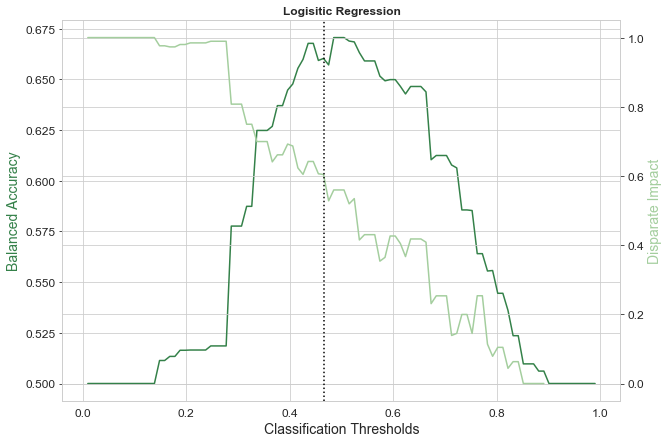

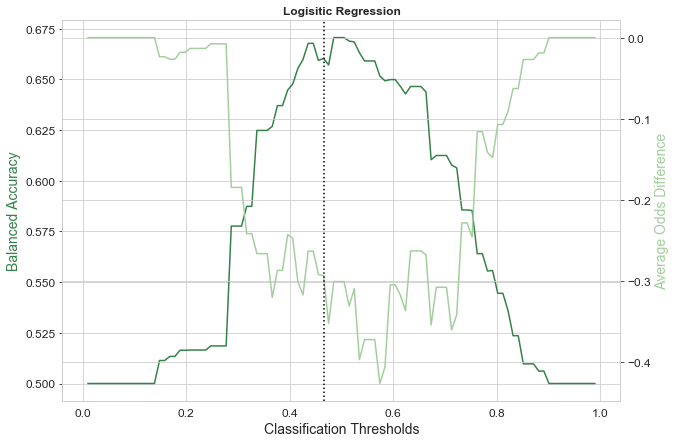

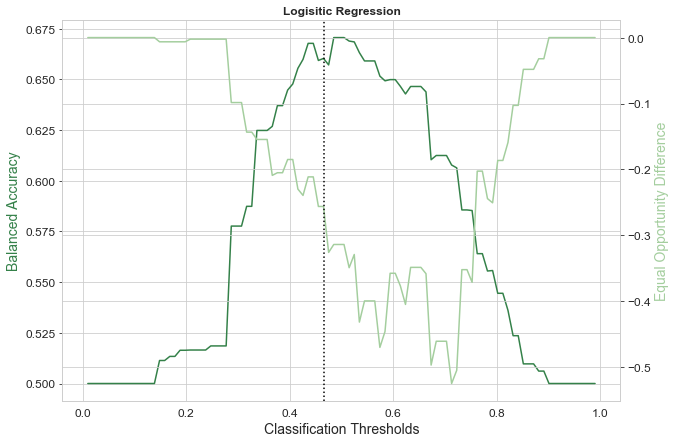

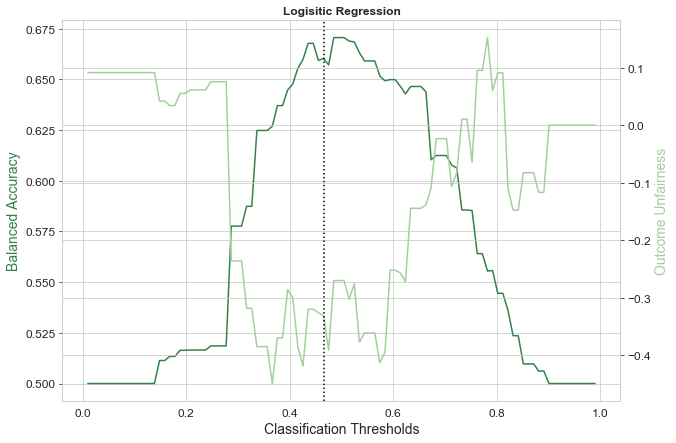

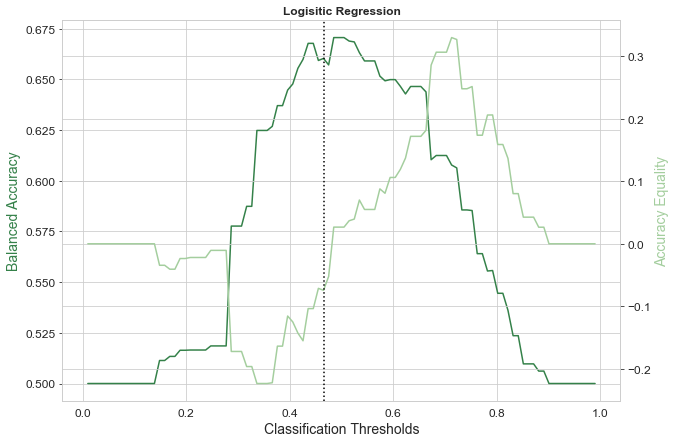

In [89]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = bal_acc_arr, model_results = LR_results, metrictitle = 'Logisitic Regression')

## Applying Bias Mitigation Techniques

### Reweighing

**Reweighing the dataset**

In [111]:
original_train_rw = original_train.copy(deepcopy = True)

In [112]:
rw = Reweighing(unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)
rw.fit(original_train_rw)
reweighed_train = rw.transform(original_train_rw)

**Calculating the weights used for each class**

The weights are calculated as follows:
$$ W_{positive privileged} = \frac{N_{privileged}*N_{positive}}{N_{all}*N_{positive privileged}} $$

In [113]:
def get_weightings(processor, dataset):
    priv_cond, unpriv_cond, fav_cond, unfav_cond, \
    cond_p_fav, cond_p_unfav, cond_up_fav, cond_up_unfav = \
        processor._obtain_conditionings(dataset)
    
    n = np.sum(dataset.instance_weights, dtype = np.float64)
    n_p = np.sum(dataset.instance_weights[priv_cond], dtype = np.float64)
    n_up = np.sum(dataset.instance_weights[unpriv_cond], dtype = np.float64)
    n_fav = np.sum(dataset.instance_weights[fav_cond], dtype = np.float64)
    n_unfav = np.sum(dataset.instance_weights[unfav_cond], dtype = np.float64)

    n_p_fav = np.sum(dataset.instance_weights[cond_p_fav], dtype = np.float64)
    n_p_unfav = np.sum(dataset.instance_weights[cond_p_unfav],
        dtype = np.float64)
    n_up_fav = np.sum(dataset.instance_weights[cond_up_fav],
        dtype = np.float64)
    n_up_unfav = np.sum(dataset.instance_weights[cond_up_unfav],
        dtype = np.float64)
    
    w_p_fav = n_fav * n_p / (n * n_p_fav)
    w_p_unfav = n_unfav * n_p / (n * n_p_unfav)
    w_up_fav = n_fav * n_up / (n * n_up_fav)
    w_up_unfav = n_unfav * n_up / (n * n_up_unfav)

    weights = {'Race': ['White', 'White', 'Non-White', 'Non-White'],
        'Label': [0.0, 1.0, 0.0, 1.0],
        'Weight': [w_p_fav, w_p_unfav, w_up_fav, w_up_unfav]}
    return weights

In [114]:
updated_weights = get_weightings(processor = rw, dataset = original_train_rw)
updated_weights = pd.DataFrame(updated_weights)
display(Markdown('#### Weights for the Reweighed training data'))
updated_weights

#### Weights for the Reweighed training data

,Race,Label,Weight
0,White,0.0,0.853343
1,White,1.0,1.240086
2,Non-White,0.0,1.125623
3,Non-White,1.0,0.888319


**Calculating fairness metrics on the reweighed dataset**

In [115]:
assert np.abs(reweighed_train.instance_weights.sum() 
    - original_train_rw.instance_weights.sum()) < 1e-6

In [116]:
reweighed_metric = BinaryLabelDatasetMetric(reweighed_train, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
reweighed_explainer = MetricTextExplainer(reweighed_metric)
display(Markdown('#### Reweighed COMPAS training data'))
print(reweighed_explainer.disparate_impact())
reweighed_train_metric = BinaryLabelDatasetMetric(reweighed_train, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % reweighed_train_metric.mean_difference())

#### Reweighed COMPAS training data

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9999999999999998
Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.000000


In [117]:
assert np.abs(reweighed_metric.mean_difference()) < 1e-6

**Training LR model on the reweighed data**

In [118]:
reweighed_scaler = StandardScaler()
X_train_rw = reweighed_scaler.fit_transform(reweighed_train.features)
y_train_rw = reweighed_train.labels.ravel()

In [119]:
lr = LogisticRegression(random_state = 1)
lr.fit(X_train_rw, y_train_rw, sample_weight = reweighed_train.instance_weights)
y_train_preds_rw = lr.predict(X_train_rw)

In [120]:
reweighed_test_preds = original_test.copy(deepcopy = True)
X_test_rw = reweighed_scaler.fit_transform(reweighed_test_preds.features)
y_test_rw = reweighed_test_preds.labels
reweighed_test_preds.scores = lr.predict_proba(X_test_rw)[:, pos_ind].reshape(-1, 1)

**Calculating results over all classification thresholds**

In [121]:
RW_bal_acc_arr = []
RW_disp_imp_arr = []
RW_avg_odds_diff_arr = []
RW_eq_opp_diff_arr = []
RW_outcome_unfair_arr = []
RW_acc_equal_arr = []

display(Markdown('#### Predictions from the transformed testing data'))
print('Classification threshold used: %.4f' % best_class_thresh)

for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    fav_inds = reweighed_test_preds.scores > thresh
    reweighed_test_preds.labels[fav_inds] = reweighed_test_preds.favorable_label
    reweighed_test_preds.labels[~fav_inds] = reweighed_test_preds.unfavorable_label
    
    rw_metric_test = compute_metrics(original_test, reweighed_test_preds, 
        unprivileged_groups, privileged_groups, disp = disp)
    rw_class_metric_test = ClassificationMetric(original_test, reweighed_test_preds, \
        unprivileged_groups, privileged_groups)
    
    RW_bal_acc_arr.append(rw_metric_test['Balanced accuracy'])
    RW_avg_odds_diff_arr.append(rw_metric_test['Average odds difference'])
    RW_disp_imp_arr.append(rw_metric_test['Disparate impact'])
    RW_eq_opp_diff_arr.append(rw_metric_test['Equal opportunity difference'])
    RW_outcome_unfair_arr.append(rw_class_metric_test.false_discovery_rate_difference() \
        + rw_class_metric_test.false_positive_rate_difference())
    RW_acc_equal_arr.append((rw_class_metric_test.true_positive_rate(privileged = True) + \
        rw_class_metric_test.true_negative_rate(privileged = True)) - \
            (rw_class_metric_test.true_positive_rate(privileged = False) + \
                rw_class_metric_test.true_negative_rate(privileged = False)))

#### Predictions from the transformed testing data

Classification threshold used: 0.5445
Balanced accuracy = 0.6682
Statistical parity difference = -0.0883
Disparate impact = 0.8263
Average odds difference = -0.0546
Equal opportunity difference = -0.0889
Theil index = 0.2734




divide by zero encountered in double_scalars


invalid value encountered in double_scalars
100%|██████████| 100/100 [00:00<00:00, 285.25it/s]


In [122]:
save_to_json(filename = 'RW_bal_acc_arr.json', data = RW_bal_acc_arr)
save_to_json(filename = 'RW_disp_imp_arr.json', data = RW_disp_imp_arr)
save_to_json(filename = 'RW_avg_odds_diff_arr.json', data = RW_avg_odds_diff_arr)
save_to_json(filename = 'RW_eq_opp_diff_arr.json', data = RW_eq_opp_diff_arr)
save_to_json(filename = 'RW_outcome_unfair_arr.json', data = RW_outcome_unfair_arr)
save_to_json(filename = 'RW_acc_equal_arr.json', data = RW_acc_equal_arr)

**Calculating results at the best classification threshold**

In [123]:
RW_bal_acc = np.interp(best_class_thresh, class_thresh_arr, RW_bal_acc_arr)
RW_acc_equal = np.interp(best_class_thresh, class_thresh_arr, RW_acc_equal_arr)
RW_disp_imp = np.interp(best_class_thresh, class_thresh_arr, RW_disp_imp_arr)
RW_out_unf = np.interp(best_class_thresh, class_thresh_arr, RW_outcome_unfair_arr)
RW_avg_odds = np.interp(best_class_thresh, class_thresh_arr, RW_avg_odds_diff_arr)
RW_eq_odds = np.interp(best_class_thresh, class_thresh_arr, RW_eq_opp_diff_arr)

In [124]:
RW_results = {'Metric': ['Balanced Accuracy', 'Accuracy Equality', 'Disparate Impact', 'Outcome Unfairess', 'Average Odds Difference', 'Equal Opportunity Difference'],
    'Reweighing': [RW_bal_acc, RW_acc_equal, RW_disp_imp, RW_out_unf, RW_avg_odds, RW_eq_odds]}
RW_results_df = pd.DataFrame(RW_results)
df_to_json(filename = 'RW_results.json', df = RW_results_df)
RW_results_df

,Metric,Reweighing
0,Balanced Accuracy,0.668212
1,Accuracy Equality,0.068752
2,Disparate Impact,0.826327
3,Outcome Unfairess,0.068237
4,Average Odds Difference,-0.054556
5,Equal Opportunity Difference,-0.088933


**Plotting each fairness metric against accuracy**

In [125]:
RW_DI = ['Disparate Impact', RW_disp_imp_arr, 'RW_disp_imp_f.png']
RW_AOD = ['Average Odds Difference', RW_avg_odds_diff_arr, 'RW_avg_odds_f.png']
RW_EOD = ['Equal Opportunity Difference', RW_eq_opp_diff_arr, 'RW_eq_opp_f.png']
RW_OU = ['Outcome Unfairness', RW_outcome_unfair_arr, 'RW_out_unf_f.png']
RW_AE = ['Accuracy Equality', RW_acc_equal_arr, 'RW_acc_eq_f.png']
RW_results = [RW_DI, RW_AOD, RW_EOD, RW_OU, RW_AE]

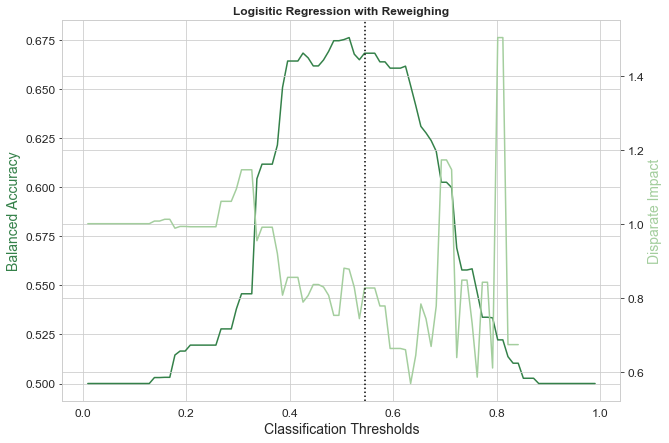

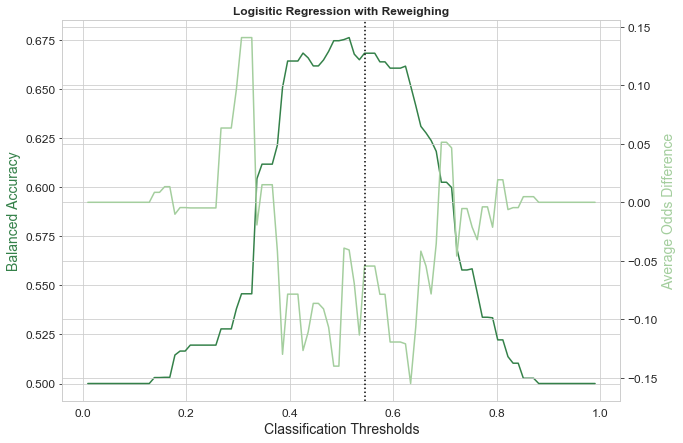

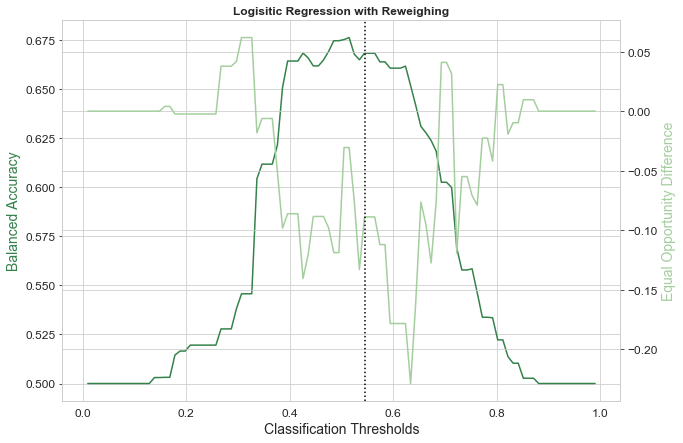

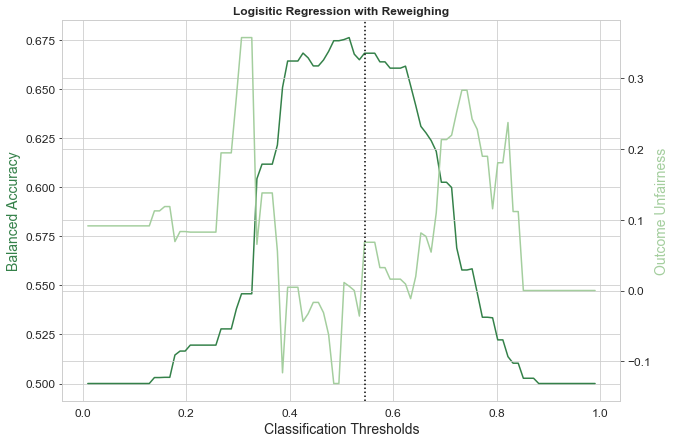

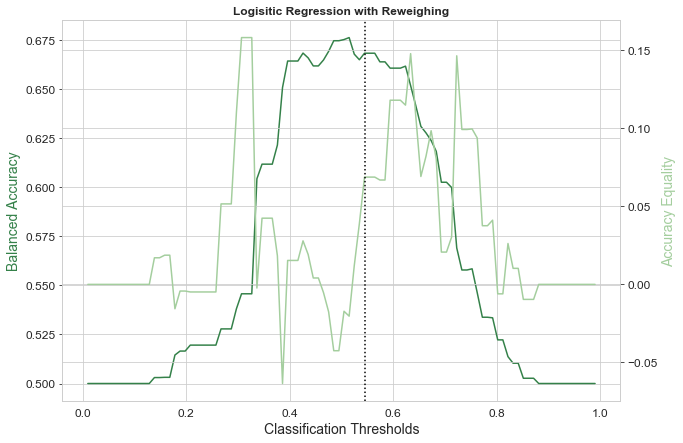

In [126]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = RW_bal_acc_arr, model_results = RW_results, metrictitle = 'Logisitic Regression with Reweighing')

### Prejudice Remover

**Training a PR model**

In [159]:
original_train_pr = original_train.copy(deepcopy = True)

sens_ind = 0
sens_attr = original_train_pr.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in original_train_pr.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in original_train_pr.privileged_protected_attributes[sens_ind]]

In [160]:
pr = PrejudiceRemover(sensitive_attr = sens_attr, eta = 25.0)
pred_scaler = StandardScaler()
pred_train = original_train_pr.copy()
pred_train.features = pred_scaler.fit_transform(pred_train.features)
pr = pr.fit(pred_train)

**Validating PR model to find optimal classification threshold**

In [161]:
pred_val = original_val.copy(deepcopy = True)
pred_val.features = pred_scaler.transform(pred_val.features)
y_train_preds_pr = pr.predict(pred_train).scores

In [162]:
PR_bal_acc_arr = []
PR_disp_imp_arr = []
PR_avg_odds_diff_arr = []
PR_eq_opp_diff_arr = []
PR_outcome_unfair_arr = []
PR_acc_equal_arr = []

In [163]:
num_thresh = 100
bal_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False

    y_val_preds = (y_train_preds_pr[:, pos_ind] > thresh).astype(np.float64)
    pred_test_preds = pred_train.copy()
    pred_test_preds.labels = y_val_preds
    
    pr_metric_test = compute_metrics(pred_train, pred_test_preds, 
        unprivileged_groups, privileged_groups, disp = disp)
    pr_class_metric_test = ClassificationMetric(pred_train, pred_test_preds, \
        unprivileged_groups, privileged_groups)
    
    PR_bal_acc_arr.append(pr_metric_test['Balanced accuracy'])
    PR_avg_odds_diff_arr.append(pr_metric_test['Average odds difference'])
    PR_disp_imp_arr.append(pr_metric_test['Disparate impact'])
    PR_eq_opp_diff_arr.append(pr_metric_test['Equal opportunity difference'])
    PR_outcome_unfair_arr.append(pr_class_metric_test.false_discovery_rate_difference() \
        + pr_class_metric_test.false_positive_rate_difference())
    PR_acc_equal_arr.append((pr_class_metric_test.true_positive_rate(privileged = True) + \
        pr_class_metric_test.true_negative_rate(privileged = True)) - \
            (pr_class_metric_test.true_positive_rate(privileged = False) + \
                pr_class_metric_test.true_negative_rate(privileged = False)))



invalid value encountered in double_scalars


divide by zero encountered in double_scalars








Balanced accuracy = 0.4669
Statistical parity difference = 0.0340
Disparate impact = 1.1409
Average odds difference = 0.0391
Equal opportunity difference = -0.0748
Theil index = 0.5760




100%|██████████| 100/100 [00:00<00:00, 174.73it/s]


In [164]:
save_to_json(filename = 'PR_bal_acc_arr.json', data = PR_bal_acc_arr)
save_to_json(filename = 'PR_disp_imp_arr.json', data = PR_disp_imp_arr)
save_to_json(filename = 'PR_avg_odds_diff_arr.json', data = PR_avg_odds_diff_arr)
save_to_json(filename = 'PR_eq_opp_diff_arr.json', data = PR_eq_opp_diff_arr)
save_to_json(filename = 'PR_outcome_unfair_arr.json', data = PR_outcome_unfair_arr)
save_to_json(filename = 'PR_acc_equal_arr.json', data = PR_acc_equal_arr)

In [165]:
PR_bal_acc = np.interp(best_class_thresh, class_thresh_arr, PR_bal_acc_arr)
PR_acc_equal = np.interp(best_class_thresh, class_thresh_arr, PR_acc_equal_arr)
PR_disp_imp = np.interp(best_class_thresh, class_thresh_arr, PR_disp_imp_arr)
PR_out_unf = np.interp(best_class_thresh, class_thresh_arr, PR_outcome_unfair_arr)
PR_avg_odds = np.interp(best_class_thresh, class_thresh_arr, PR_avg_odds_diff_arr)
PR_eq_odds = np.interp(best_class_thresh, class_thresh_arr, PR_eq_opp_diff_arr)

In [166]:
PR_results = {'Metric': ['Balanced Accuracy', 'Accuracy Equality', 'Disparate Impact', 'Outcome Unfairess', 'Average Odds Difference', 'Equal Opportunity Difference'],
    'Prejudice Remover': [PR_bal_acc, PR_acc_equal, PR_disp_imp, PR_out_unf, PR_avg_odds, PR_eq_odds]}
PR_results_df = pd.DataFrame(PR_results)
df_to_json(filename = 'PR_results.json', df = PR_results_df)
PR_results_df

,Metric,Prejudice Remover
0,Balanced Accuracy,0.466852
1,Accuracy Equality,0.227804
2,Disparate Impact,1.140934
3,Outcome Unfairess,0.514644
4,Average Odds Difference,0.039131
5,Equal Opportunity Difference,-0.074771


### Adversarial Debiasing

In [12]:
# session.close()
# tf.reset_default_graph()
session = tf.Session()

In [13]:
X, y = fetch_compas(binary_race = True)
X.index = pd.MultiIndex.from_arrays(X.index.codes, names = X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names = y.index.names)
y = 1 - pd.Series(y.factorize(sort = True)[0], index = y.index)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
data_preproc = make_column_transformer((OneHotEncoder(sparse = False, handle_unknown = 'ignore'), 
        X_train.dtypes == 'category'), remainder = StandardScaler())
X_train = pd.DataFrame(data_preproc.fit_transform(X_train), index = X_train.index)
X_test = pd.DataFrame(data_preproc.transform(X_test), index = X_test.index)

**Hyperparameter Training: finding optimal adversary loss weight**

In [15]:
def find_loss_weights(loss_weights):
    weights = {'Adversarial Loss Weight': [], 'Mean Accuracy': []}
    for weight in loss_weights:
        ad = SKLearnAdversarialDebiasing(prot_attr = 'race', adversary_loss_weight = weight)
        ad = ad.fit(X_train, y_train)
        acc_score = ad.score(X_train, y_train)
        weights['Adversarial Loss Weight'].append(weight)
        weights['Mean Accuracy'].append(acc_score)
    return pd.DataFrame(weights)

In [16]:
loss_weights = [i for i in np.linspace(0.01, 1.0, 100)]
weights = find_loss_weights(loss_weights = loss_weights)

In [17]:
def plot_params(param, metric, param_data, best_x, best_y, title, file_name):
    plt.figure(figsize = (12, 8))
    sns.set_style('whitegrid')
    ax = sns.lineplot(x = param, y = metric, data = param_data, color = '#b3d6ad', markers = 'o')
    if param == 'Adversarial Loss Weight':
        ax.annotate(s = ' x = {:.2f}, y = {:.2f}'.format(best_x, best_y), xy = (best_x, best_y))
    elif param == 'Number of Hidden Units':
        ax.annotate(s = ' x = {:}, \n y = {:.2f}'.format(best_x, best_y), xy = (best_x, best_y))
    plt.title(title)
    plt.savefig(file_name, bbox_inches = 'tight')

In [18]:
max = weights['Mean Accuracy'].max()
weight = weights.loc[weights['Mean Accuracy'] == max]
print(weight)

    Adversarial Loss Weight  Mean Accuracy
24                     0.25       0.789074


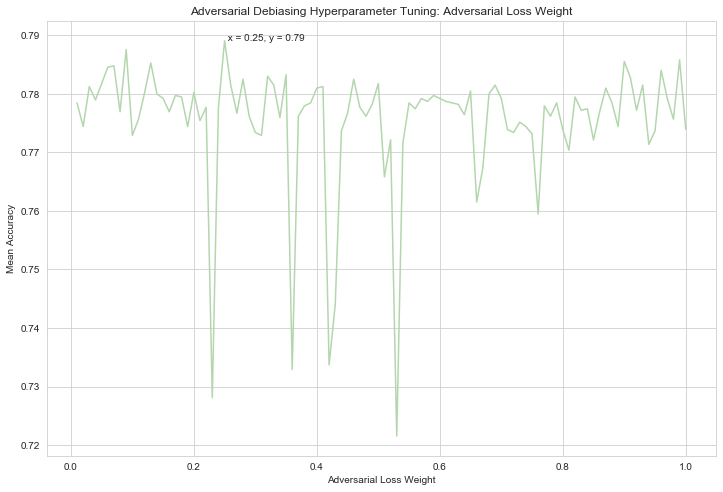

In [19]:
plot_params(param = 'Adversarial Loss Weight', metric = 'Mean Accuracy', 
    param_data = weights, best_x = 0.25, best_y = 0.789074,
    file_name = 'debiased_params_weights.png',
    title = 'Adversarial Debiasing Hyperparameter Tuning: Adversarial Loss Weight')

**Hyperparameter Training: finding optimal number of hidden units**

In [20]:
def find_hidden_units(num_hidden_units):
    units = {'Number of Hidden Units': [], 'Mean Accuracy': []}
    for unit in num_hidden_units:
        ad = SKLearnAdversarialDebiasing(prot_attr = 'race', classifier_num_hidden_units = unit)
        ad.fit(X_train, y_train)
        acc_score = ad.score(X_train, y_train)
        units['Number of Hidden Units'].append(unit)
        units['Mean Accuracy'].append(acc_score)
    return pd.DataFrame(units)

In [21]:
num_hidden_units = [int(i) for i in np.linspace(1, 500, 100)]
units = find_hidden_units(num_hidden_units = num_hidden_units)

In [22]:
max = units['Mean Accuracy'].max()
unit = units.loc[units['Mean Accuracy'] == max]
print(unit)

    Number of Hidden Units  Mean Accuracy
93                     469       0.806019


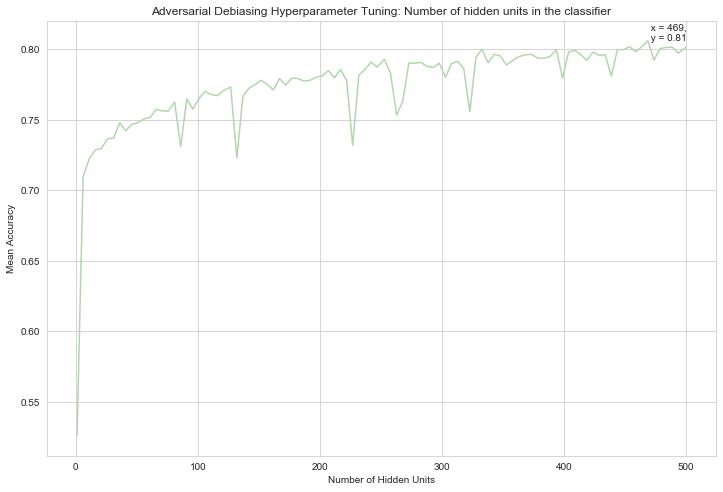

In [23]:
plot_params(param = 'Number of Hidden Units', param_data = units, metric = 'Mean Accuracy',
    title = 'Adversarial Debiasing Hyperparameter Tuning: Number of hidden units in the classifier', 
    file_name = 'debiased_params_units.png', best_x = 469, best_y = 0.806019)

**Training AD model with optimal hyperparameters**

In [73]:
session.close()
tf.reset_default_graph()
session = tf.Session()

In [74]:
ad = AdversarialDebiasing(privileged_groups = privileged_groups, 
    unprivileged_groups = unprivileged_groups, scope_name = 'debiased_classifier', 
    debias = True, sess = session, num_epochs = 100, batch_size = 8,
    classifier_num_hidden_units = 469, adversary_loss_weight = 0.25)
debiased_scaler = StandardScaler()
debiased_train = original_train.copy(deepcopy = True)
debiased_train.features = debiased_scaler.fit_transform(debiased_train.features)
ad = ad.fit(debiased_train)

epoch 0; iter: 0; batch classifier loss: 0.690613; batch adversarial loss: 0.682198
epoch 0; iter: 200; batch classifier loss: 0.526836; batch adversarial loss: 0.579574
epoch 1; iter: 0; batch classifier loss: 0.666613; batch adversarial loss: 0.648435
epoch 1; iter: 200; batch classifier loss: 0.639374; batch adversarial loss: 0.765866
epoch 2; iter: 0; batch classifier loss: 0.435615; batch adversarial loss: 0.657977
epoch 2; iter: 200; batch classifier loss: 0.650008; batch adversarial loss: 0.603986
epoch 3; iter: 0; batch classifier loss: 0.587021; batch adversarial loss: 0.559579
epoch 3; iter: 200; batch classifier loss: 0.444792; batch adversarial loss: 0.473457
epoch 4; iter: 0; batch classifier loss: 0.471620; batch adversarial loss: 0.889729
epoch 4; iter: 200; batch classifier loss: 0.696393; batch adversarial loss: 0.604106
epoch 5; iter: 0; batch classifier loss: 0.650812; batch adversarial loss: 0.710119
epoch 5; iter: 200; batch classifier loss: 0.435716; batch adversa

In [75]:
debiased_val = original_val.copy(deepcopy = True)
debiased_val.features = debiased_scaler.transform(debiased_val.features)
y_train_preds_db = ad.predict(debiased_train).scores

In [76]:
AD_bal_acc_arr = []
AD_disp_imp_arr = []
AD_avg_odds_diff_arr = []
AD_eq_opp_diff_arr = []
AD_outcome_unfair_arr = []
AD_acc_equal_arr = []

In [77]:
for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False

    y_val_preds = (y_train_preds_db[:, pos_ind] > thresh).astype(np.float64)
    debiased_test_preds = debiased_train.copy()
    debiased_test_preds.labels = y_val_preds

    ad_metric_test = compute_metrics(debiased_train, debiased_test_preds, \
        unprivileged_groups, privileged_groups, disp = disp)
    ad_class_metric_test = ClassificationMetric(debiased_train, debiased_test_preds, \
        unprivileged_groups, privileged_groups)
    
    AD_bal_acc_arr.append(ad_metric_test['Balanced accuracy'])
    AD_avg_odds_diff_arr.append(ad_metric_test['Average odds difference'])
    AD_disp_imp_arr.append(ad_metric_test['Disparate impact'])
    AD_eq_opp_diff_arr.append(ad_metric_test['Equal opportunity difference'])
    AD_outcome_unfair_arr.append(ad_class_metric_test.false_discovery_rate_difference() \
        + ad_class_metric_test.false_positive_rate_difference())
    AD_acc_equal_arr.append((ad_class_metric_test.true_positive_rate(privileged = True) + \
        ad_class_metric_test.true_negative_rate(privileged = True)) - \
            (ad_class_metric_test.true_positive_rate(privileged = False) + \
                ad_class_metric_test.true_negative_rate(privileged = False)))



invalid value encountered in double_scalars
divide by zero encountered in double_scalars










Balanced accuracy = 0.3338
Statistical parity difference = 0.1221
Disparate impact = 1.2884
Average odds difference = 0.0757
Equal opportunity difference = 0.0607
Theil index = 0.4865




100%|██████████| 100/100 [00:00<00:00, 185.09it/s]


In [78]:
save_to_json(filename = 'AD_bal_acc_arr.json', data = AD_bal_acc_arr)
save_to_json(filename = 'AD_disp_imp_arr.json', data = AD_disp_imp_arr)
save_to_json(filename = 'AD_avg_odds_diff_arr.json', data = AD_avg_odds_diff_arr)
save_to_json(filename = 'AD_eq_opp_diff_arr.json', data = AD_eq_opp_diff_arr)
save_to_json(filename = 'AD_outcome_unfair_arr.json', data = AD_outcome_unfair_arr)
save_to_json(filename = 'AD_acc_equal_arr.json', data = AD_acc_equal_arr)

In [79]:
AD_bal_acc = np.interp(best_class_thresh, class_thresh_arr, AD_bal_acc_arr)
AD_acc_equal = np.interp(best_class_thresh, class_thresh_arr, AD_acc_equal_arr)
AD_disp_imp = np.interp(best_class_thresh, class_thresh_arr, AD_disp_imp_arr)
AD_out_unf = np.interp(best_class_thresh, class_thresh_arr, AD_outcome_unfair_arr)
AD_avg_odds = np.interp(best_class_thresh, class_thresh_arr, AD_avg_odds_diff_arr)
AD_eq_odds = np.interp(best_class_thresh, class_thresh_arr, AD_eq_opp_diff_arr)

In [80]:
AD_results = {'Metric': ['Balanced Accuracy', 'Accuracy Equality', 'Disparate Impact', 'Outcome Unfairess', 'Average Odds Difference', 'Equal Opportunity Difference'],
    'Adversarial Debiasing': [AD_bal_acc, AD_acc_equal, AD_disp_imp, AD_out_unf, AD_avg_odds, AD_eq_odds]}
AD_results_df = pd.DataFrame(AD_results)
df_to_json(filename = 'AD_results.json', df = AD_results_df)
AD_results_df

,Metric,Adversarial Debiasing
0,Balanced Accuracy,0.333776
1,Accuracy Equality,0.030141
2,Disparate Impact,1.288419
3,Outcome Unfairess,0.224635
4,Average Odds Difference,0.075733
5,Equal Opportunity Difference,0.060663


In [91]:
AD_DI = ['Disparate Impact', AD_disp_imp_arr, 'RW_disp_imp_f.png']
AD_AOD = ['Average Odds Difference', AD_avg_odds_diff_arr, 'RW_avg_odds_f.png']
AD_EOD = ['Equal Opportunity Difference', AD_eq_opp_diff_arr, 'RW_eq_opp_f.png']
AD_OU = ['Outcome Unfairness', AD_outcome_unfair_arr, 'RW_out_unf_f.png']
AD_AE = ['Accuracy Equality', AD_acc_equal_arr, 'RW_acc_eq_f.png']
AD_results = [AD_DI, AD_AOD, AD_EOD, AD_OU, AD_AE]

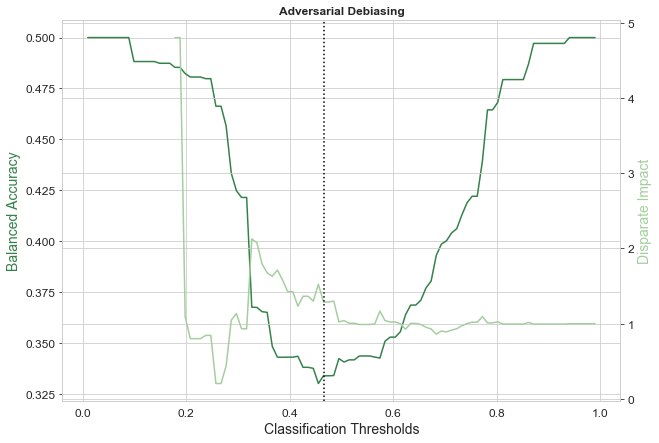

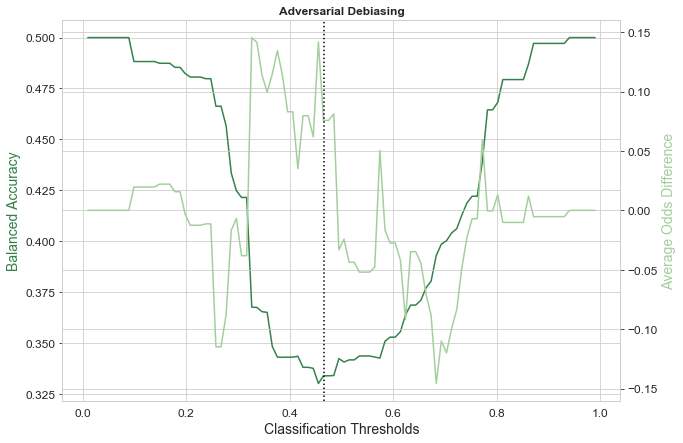

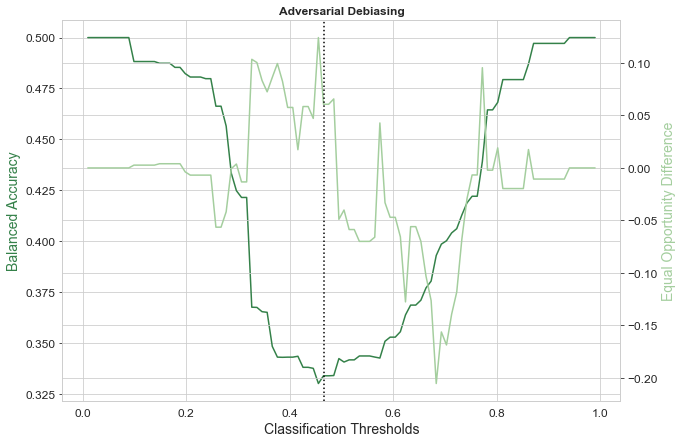

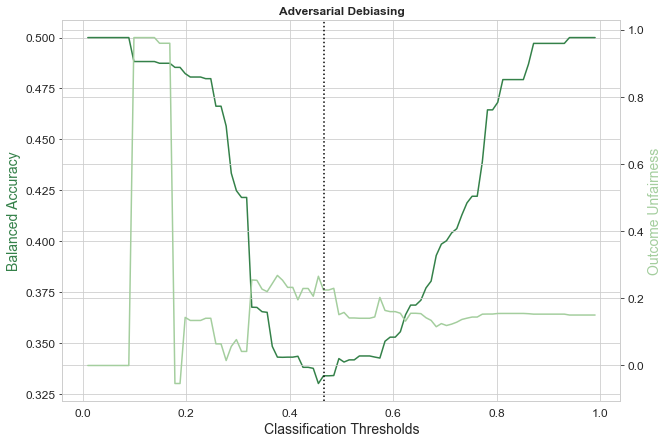

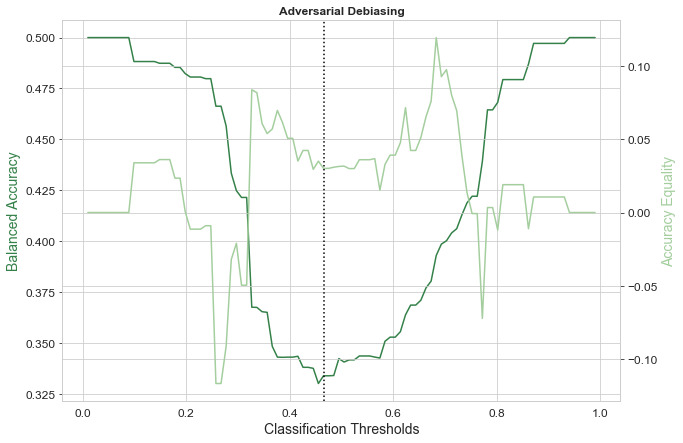

In [92]:
plot_graphs(class_thresholds = class_thresh_arr, best_threshold = best_class_thresh, 
    balanced_acc = AD_bal_acc_arr, model_results = AD_results, metrictitle = 'Adversarial Debiasing')

### Reject-option Classification - tune HP for DI

In [81]:
pre_scaler = StandardScaler()
pre_train = original_train.copy(deepcopy = True)
pre_train_preds = original_train.copy(deepcopy = True)
pre_X_train = pre_scaler.fit_transform(pre_train.features)
pre_y_train = pre_train.labels.ravel()

lr = LogisticRegression()
lr.fit(pre_X_train, pre_y_train)
y_train_preds_pre = lr.predict(pre_X_train)

# positive class index
pos_ind = np.where(lr.classes_ == pre_train.favorable_label)[0][0]
pre_train_preds.labels = y_train_preds_pre

pre_val = original_val.copy(deepcopy = True)
pre_val_preds = original_val.copy(deepcopy = True)
X_valid = pre_scaler.transform(pre_val_preds.features)
y_valid = pre_val_preds.labels
pre_val_preds.scores = lr.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

pre_test = original_test.copy(deepcopy = True)
pre_test_preds = original_test.copy(deepcopy = True)
X_test = pre_scaler.transform(pre_test_preds.features)
y_test = pre_test_preds.labels
pre_test_preds.scores = lr.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [82]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = pre_val_preds.scores > class_thresh
    pre_val_preds.labels[fav_inds] = pre_val_preds.favorable_label
    pre_val_preds.labels[~fav_inds] = pre_val_preds.unfavorable_label
    
    pre_val_classified_metric = ClassificationMetric(pre_val,
        pre_val_preds, unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(pre_val_classified_metric.true_positive_rate()\
                       + pre_val_classified_metric.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

display(Markdown('#### Without fairness constraints'))
print("Best balanced accuracy: %.4f" % np.max(ba_arr))
print("Optimal classification threshold: %.4f" % best_class_thresh)

#### Without fairness constraints

Best balanced accuracy: 0.6583
Optimal classification threshold: 0.4654


**Finding the fairness metric to be constrained**

In [83]:
def find_fairness_metric(metric_names):
    metrics = {'Metric': [], 'Optimal Classification Threshold': [], 'ROC Margin': []}
    for metric in metric_names:
        metrics['Metric'].append(metric)
        roc = RejectOptionClassification(unprivileged_groups = unprivileged_groups, 
            privileged_groups = privileged_groups, low_class_thresh = 0.01, 
            high_class_thresh = 0.99, num_class_thresh = 100, num_ROC_margin = 50, 
            metric_name = metric, metric_ub = 0.05, metric_lb = -0.05)
        roc = roc.fit(pre_val, pre_val_preds)
        metrics['Optimal Classification Threshold'].append(roc.classification_threshold)
        metrics['ROC Margin'].append(roc.ROC_margin)
    return pd.DataFrame(metrics)

In [84]:
metric_names = ['Average odds difference', 'Statistical parity difference', 'Equal opportunity difference']
find_fairness_metric(metric_names = metric_names)

,Metric,Optimal Classification Threshold,ROC Margin
0,Average odds difference,0.544545,0.074360
1,Statistical parity difference,0.514848,0.108912
2,Equal opportunity difference,0.544545,0.074360


In [85]:
def find_metric_bounds(upperbounds, lowerbounds):
    bounds = {'Upper Bound': [], 'Lower Bound': [], 'Optimal Classification Threshold': [], 'ROC Margin': [], 'Tradeoff': []}
    for (lower, upper) in [(lower, upper) for lower in lowerbounds for upper in upperbounds]:
        roc = RejectOptionClassification(unprivileged_groups = unprivileged_groups, 
            privileged_groups = privileged_groups, low_class_thresh = 0.01, 
            high_class_thresh = 0.99, num_class_thresh = 100, num_ROC_margin = 50, 
            metric_name = 'Equal opportunity difference', metric_ub = upper, metric_lb = lower)
        roc = roc.fit(pre_val, pre_val_preds)
        bounds['Upper Bound'].append(upper)
        bounds['Lower Bound'].append(lower)
        bounds['Optimal Classification Threshold'].append(roc.classification_threshold)
        bounds['ROC Margin'].append(roc.ROC_margin)
        bounds['Tradeoff'].append(roc.classification_threshold - roc.ROC_margin)
    return pd.DataFrame(bounds)

In [93]:
lowerbounds = [-1, -0.5, -0.1, -0.05, -0.01]
upperbounds = [1, 0.5, 0.1, 0.05, 0.01]
bounds = find_metric_bounds(upperbounds = upperbounds, lowerbounds = lowerbounds)

In [94]:
# we want to choose fairness metric which maximises the classification threshold while satisfying the fairness constraint, therefore SPD has been chosen
# we want to choose upper and lower bounds that maximises the classification threshold while satisfying the fairness constraint, therefore ub = and lb = has been chosen
roc = RejectOptionClassification(unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups, low_class_thresh = 0.01, 
    high_class_thresh = 0.99, num_class_thresh = 100, num_ROC_margin = 50, 
    metric_name = 'Equal opportunity difference', metric_ub = 0.01, metric_lb = -0.01)
roc = roc.fit(pre_val, pre_val_preds)

In [95]:
display(Markdown('#### With fairness constraints'))
print("Optimal classification threshold (with fairness constraints) = %.4f" % roc.classification_threshold)
print("Optimal ROC margin = %.4f" % roc.ROC_margin)

#### With fairness constraints

Optimal classification threshold (with fairness constraints) = 0.5445
Optimal ROC margin = 0.0744


In [96]:
post_val_preds = roc.predict(pre_val_preds)
display(Markdown('#### Transformed predictions - with fairness constraints'))

post_roc_metric = compute_metrics(pre_val, post_val_preds, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)

#### Transformed predictions - with fairness constraints

Balanced accuracy = 0.6601
Statistical parity difference = -0.0790
Disparate impact = 0.8635
Average odds difference = -0.0429
Equal opportunity difference = 0.0016
Theil index = 0.2326


In [97]:
post_test_preds = roc.predict(pre_test_preds)
display(Markdown('#### Transformed predictions - with fairness constraints'))

post_roc_metric = compute_metrics(original_test, post_test_preds, 
    unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)

#### Transformed predictions - with fairness constraints

Balanced accuracy = 0.6679
Statistical parity difference = -0.0955
Disparate impact = 0.8351
Average odds difference = -0.0646
Equal opportunity difference = -0.0714
Theil index = 0.2348


In [105]:
ROC_bal_acc_arr = []
ROC_disp_imp_arr = []
ROC_avg_odds_diff_arr = []
ROC_eq_opp_diff_arr = []
ROC_outcome_unfair_arr = []
ROC_acc_equal_arr = []

In [106]:
print(roc.classification_threshold)
print(best_class_thresh)

0.5445454545454546
0.5445454545454546


In [107]:
best_class_thresh = roc.classification_threshold

for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
   
    fav_inds = post_test_preds.scores > thresh

    post_test_preds.labels[fav_inds] = post_test_preds.favorable_label
    post_test_preds.labels[~fav_inds] = post_test_preds.unfavorable_label

    roc_metric_test = compute_metrics(original_test, post_test_preds, disp = disp,
        unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
    roc_class_metric_test = ClassificationMetric(original_test, post_test_preds, \
        unprivileged_groups, privileged_groups)

    ROC_bal_acc_arr.append(roc_metric_test['Balanced accuracy'])
    ROC_avg_odds_diff_arr.append(roc_metric_test['Average odds difference'])
    ROC_disp_imp_arr.append(roc_metric_test['Disparate impact'])
    ROC_eq_opp_diff_arr.append(roc_metric_test['Equal opportunity difference'])
    ROC_outcome_unfair_arr.append(roc_class_metric_test.false_discovery_rate_difference() \
        + roc_class_metric_test.false_positive_rate_difference())
    ROC_acc_equal_arr.append((roc_class_metric_test.true_positive_rate(privileged = True) + \
        roc_class_metric_test.true_negative_rate(privileged = True)) - \
            (roc_class_metric_test.true_positive_rate(privileged = False) + \
                roc_class_metric_test.true_negative_rate(privileged = False)))









100%|██████████| 100/100 [00:00<00:00, 259.07it/s]

Balanced accuracy = 0.6591
Statistical parity difference = -0.4008
Disparate impact = 0.4303
Average odds difference = -0.3720
Equal opportunity difference = -0.3994
Theil index = 0.2751


In [108]:
save_to_json(filename = 'ROC_bal_acc_arr.json', data = ROC_bal_acc_arr)
save_to_json(filename = 'ROC_disp_imp_arr.json', data = ROC_disp_imp_arr)
save_to_json(filename = 'ROC_avg_odds_diff_arr.json', data = ROC_avg_odds_diff_arr)
save_to_json(filename = 'ROC_eq_opp_diff_arr.json', data = ROC_eq_opp_diff_arr)
save_to_json(filename = 'ROC_outcome_unfair_arr.json', data = ROC_outcome_unfair_arr)
save_to_json(filename = 'ROC_acc_equal_arr.json', data = ROC_acc_equal_arr)

In [109]:
ROC_bal_acc = np.interp(best_class_thresh, class_thresh_arr, ROC_bal_acc_arr)
ROC_acc_equal = np.interp(best_class_thresh, class_thresh_arr, ROC_acc_equal_arr)
ROC_disp_imp = np.interp(best_class_thresh, class_thresh_arr, ROC_disp_imp_arr)
ROC_out_unf = np.interp(best_class_thresh, class_thresh_arr, ROC_outcome_unfair_arr)
ROC_avg_odds = np.interp(best_class_thresh, class_thresh_arr, ROC_avg_odds_diff_arr)
ROC_eq_odds = np.interp(best_class_thresh, class_thresh_arr, ROC_eq_opp_diff_arr)

In [110]:
ROC_results = {'Metric': ['Balanced Accuracy', 'Accuracy Equality', 'Disparate Impact', 'Outcome Unfairess', 'Average Odds Difference', 'Equal Opportunity Difference'],
    'Reject-option Classification': [ROC_bal_acc, ROC_acc_equal, ROC_disp_imp, ROC_out_unf, ROC_avg_odds, ROC_eq_odds]}
ROC_results_df = pd.DataFrame(ROC_results)
df_to_json(filename = 'ROC_results.json', df = ROC_results_df)
ROC_results_df

,Metric,Reject-option Classification
0,Balanced Accuracy,0.659121
1,Accuracy Equality,0.054812
2,Disparate Impact,0.430251
3,Outcome Unfairess,-0.361021
4,Average Odds Difference,-0.372038
5,Equal Opportunity Difference,-0.399444


### Calibrated Equalised-odds Difference

In [127]:
pre_scaler = StandardScaler()
pre_train = original_train.copy(deepcopy = True)
pre_train_preds = original_train.copy(deepcopy = True)
pre_X_train = pre_scaler.fit_transform(pre_train.features)
pre_y_train = pre_train.labels.ravel()

lr = LogisticRegression()
lr.fit(pre_X_train, pre_y_train)
y_train_preds_pre = lr.predict(pre_X_train)

# positive class index
pos_ind = np.where(lr.classes_ == pre_train.favorable_label)[0][0]
pre_train_preds.labels = y_train_preds_pre

pre_val = original_val.copy(deepcopy = True)
pre_val_preds = original_val.copy(deepcopy = True)
X_valid = pre_scaler.transform(pre_val_preds.features)
y_valid = pre_val_preds.labels
pre_val_preds.scores = lr.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

pre_test = original_test.copy(deepcopy = True)
pre_test_preds = original_test.copy(deepcopy = True)
X_test = pre_scaler.transform(pre_test_preds.features)
y_test = pre_test_preds.labels
pre_test_preds.scores = lr.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [128]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = pre_val_preds.scores > class_thresh
    pre_val_preds.labels[fav_inds] = pre_val_preds.favorable_label
    pre_val_preds.labels[~fav_inds] = pre_val_preds.unfavorable_label
    
    pre_val_classified_metric = ClassificationMetric(pre_val,
        pre_val_preds, unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(pre_val_classified_metric.true_positive_rate()\
                       + pre_val_classified_metric.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

In [129]:
pre_val_metric = ClassificationMetric(pre_val, pre_val_preds, unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)
pre_test_metric = ClassificationMetric(pre_test, pre_test_preds, unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)

In [130]:
def get_cost_constraint(constraints, dataset):
    validation_constraints = {'Cost Constraint': [], 'Difference in GFPR': [], 'Difference in GFNR': []}
    testing_constraints = {'Cost Constraint': [], 'Difference in GFPR': [], 'Difference in GFNR': []}
    if dataset == 'Validation':
        for constraint in constraints:
            ceo = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups, unprivileged_groups = unprivileged_groups, 
                cost_constraint = constraint, seed = 12345679)
            ceo.fit(pre_val, pre_val_preds)
            post_val_preds = ceo.predict(pre_val_preds)
            post_val_metric = ClassificationMetric(pre_val_preds, post_val_preds, unprivileged_groups = unprivileged_groups, 
                privileged_groups = privileged_groups)
            validation_constraints['Cost Constraint'].append(constraint)
            validation_constraints['Difference in GFPR'].append(post_val_metric.difference(post_val_metric.generalized_false_positive_rate))
            validation_constraints['Difference in GFNR'].append(post_val_metric.difference(post_val_metric.generalized_false_negative_rate))
        return pd.DataFrame(validation_constraints)
    elif dataset == 'Testing':
        for constraint in constraints:
            ceo = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups, unprivileged_groups = unprivileged_groups, 
                cost_constraint = constraint, seed = 12345679)
            ceo.fit(pre_test, pre_test_preds)
            post_test_preds = ceo.predict(pre_test_preds)
            post_test_metric = ClassificationMetric(pre_test_preds, post_test_preds, unprivileged_groups = unprivileged_groups, 
                privileged_groups = privileged_groups)
            testing_constraints['Cost Constraint'].append(constraint)
            testing_constraints['Difference in GFPR'].append(post_test_metric.difference(post_test_metric.generalized_false_positive_rate))
            testing_constraints['Difference in GFNR'].append(post_test_metric.difference(post_test_metric.generalized_false_negative_rate))       
        return pd.DataFrame(testing_constraints)

In [131]:
constraints = ['fpr', 'fnr', 'weighted']
get_cost_constraint(constraints = constraints, dataset = 'Validation')

invalid value encountered in double_scalars
invalid value encountered in double_scalars


,Cost Constraint,Difference in GFPR,Difference in GFNR
0,fpr,-0.155409,NaN
1,fnr,-0.139837,NaN
2,weighted,-0.163438,NaN


In [132]:
get_cost_constraint(constraints = constraints, dataset = 'Testing')

,Cost Constraint,Difference in GFPR,Difference in GFNR
0,fpr,-0.050958,0.193729
1,fnr,-0.181886,0.062648
2,weighted,-0.158440,0.125867


In [143]:
ceo = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups, 
    unprivileged_groups = unprivileged_groups, cost_constraint = 'fnr')
ceo.fit(pre_val, pre_val_preds)
post_val_preds = ceo.predict(pre_val_preds)
post_test_preds = ceo.predict(pre_test_preds)

In [144]:
post_val_metric = ClassificationMetric(pre_val, post_val_preds, unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)
post_test_metric = ClassificationMetric(pre_test, post_test_preds, unprivileged_groups = unprivileged_groups, 
    privileged_groups = privileged_groups)

In [145]:
assert np.abs(post_val_metric.difference(post_val_metric.generalized_false_negative_rate)) < \
    np.abs(pre_val_metric.difference(pre_val_metric.generalized_false_negative_rate))

In [146]:
assert np.abs(post_test_metric.difference(post_test_metric.generalized_false_negative_rate)) < \
    np.abs(pre_test_metric.difference(pre_test_metric.generalized_false_negative_rate))

In [147]:
CEOD_bal_acc_arr = []
CEOD_disp_imp_arr = []
CEOD_avg_odds_diff_arr = []
CEOD_eq_opp_diff_arr = []
CEOD_outcome_unfair_arr = []
CEOD_acc_equal_arr = []

In [148]:
display(Markdown('#### Predictions from the original testing data'))
print('Classification threshold used: %.4f' % best_class_thresh)

for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False

    fav_inds = post_test_preds.scores > thresh
    post_test_preds.labels[fav_inds] = post_test_preds.favorable_label
    post_test_preds.labels[~fav_inds] = post_test_preds.unfavorable_label
    
    ceod_metric_test = compute_metrics(pre_test, post_test_preds, \
        unprivileged_groups, privileged_groups, disp = disp)
    ceod_class_metric_test = ClassificationMetric(pre_test, post_test_preds, \
        unprivileged_groups, privileged_groups)
    
    CEOD_bal_acc_arr.append(ceod_metric_test['Balanced accuracy'])
    CEOD_avg_odds_diff_arr.append(ceod_metric_test['Average odds difference'])
    CEOD_disp_imp_arr.append(ceod_metric_test['Disparate impact'])
    CEOD_eq_opp_diff_arr.append(ceod_metric_test['Equal opportunity difference'])
    CEOD_outcome_unfair_arr.append(ceod_class_metric_test.false_discovery_rate_difference() \
        + ceod_class_metric_test.false_positive_rate_difference())
    CEOD_acc_equal_arr.append((ceod_class_metric_test.true_positive_rate(privileged = True) + \
        ceod_class_metric_test.true_negative_rate(privileged = True)) - \
            (ceod_class_metric_test.true_positive_rate(privileged = False) + \
                ceod_class_metric_test.true_negative_rate(privileged = False)))

#### Predictions from the original testing data

Classification threshold used: 0.4654
Balanced accuracy = 0.6201
Statistical parity difference = -0.5166
Disparate impact = 0.4834
Average odds difference = -0.5148
Equal opportunity difference = -0.3526
Theil index = 0.1673




divide by zero encountered in double_scalars


100%|██████████| 100/100 [00:00<00:00, 265.18it/s]


In [149]:
save_to_json(filename = 'CEOD_bal_acc_arr.json', data = CEOD_bal_acc_arr)
save_to_json(filename = 'CEOD_disp_imp_arr.json', data = CEOD_disp_imp_arr)
save_to_json(filename = 'CEOD_avg_odds_diff_arr.json', data = CEOD_avg_odds_diff_arr)
save_to_json(filename = 'CEOD_eq_opp_diff_arr.json', data = CEOD_eq_opp_diff_arr)
save_to_json(filename = 'CEOD_outcome_unfair_arr.json', data = CEOD_outcome_unfair_arr)
save_to_json(filename = 'CEOD_acc_equal_arr.json', data = CEOD_acc_equal_arr)

In [150]:
CEOD_bal_acc = np.interp(best_class_thresh, class_thresh_arr, CEOD_bal_acc_arr)
CEOD_acc_equal = np.interp(best_class_thresh, class_thresh_arr, CEOD_acc_equal_arr)
CEOD_disp_imp = np.interp(best_class_thresh, class_thresh_arr, CEOD_disp_imp_arr)
CEOD_out_unf = np.interp(best_class_thresh, class_thresh_arr, CEOD_outcome_unfair_arr)
CEOD_avg_odds = np.interp(best_class_thresh, class_thresh_arr, CEOD_avg_odds_diff_arr)
CEOD_eq_odds = np.interp(best_class_thresh, class_thresh_arr, CEOD_eq_opp_diff_arr)

In [151]:
CEOD_results = {'Metric': ['Balanced Accuracy', 'Accuracy Equality', 'Disparate Impact', 'Outcome Unfairess', 'Average Odds Difference', 'Equal Opportunity Difference'],
    'Calibrated Equal Odds': [CEOD_bal_acc, CEOD_acc_equal, CEOD_disp_imp, CEOD_out_unf, CEOD_avg_odds, CEOD_eq_odds]}
CEOD_results_df = pd.DataFrame(CEOD_results)
df_to_json(filename = 'CEOD_results.json', df = CEOD_results_df)
CEOD_results_df

,Metric,Calibrated Equal Odds
0,Balanced Accuracy,0.620143
1,Accuracy Equality,-0.324552
2,Disparate Impact,0.483360
3,Outcome Unfairess,-0.753529
4,Average Odds Difference,-0.514840
5,Equal Opportunity Difference,-0.352564


## Cross-model Comparison

### Results at the best classification threshold

In [152]:
LR = json_to_data(filename = 'LR_results.json')
RW = json_to_data(filename = 'RW_results.json')
AD = json_to_data(filename = 'AD_results.json')
PR = json_to_data(filename = 'PR_results.json')
ROC = json_to_data(filename = 'ROC_results.json')
CEOD = json_to_data(filename = 'CEOD_results.json')

In [153]:
RW = RW.drop(columns = ['Metric'], axis = 1)
AD = AD.drop(columns = ['Metric'], axis = 1)
PR = PR.drop(columns = ['Metric'], axis = 1)
ROC = ROC.drop(columns = ['Metric'], axis = 1)
CEOD = CEOD.drop(columns = ['Metric'], axis = 1)

In [154]:
results = pd.concat([LR, RW, AD, PR, ROC, CEOD], axis = 1)
results

,Metric,Logistic Regression,Reweighing,Adversarial Debiasing,Prejudice Remover,Reject-option Classification,Calibrated Equal Odds
0,Balanced Accuracy,0.663825,0.668212,0.333776,0.395684,0.659121,0.620143
1,Accuracy Equality,-0.153888,0.068752,0.030141,0.176415,0.054812,-0.324552
2,Disparate Impact,0.594951,0.826327,1.288419,1.853844,0.430251,0.483360
3,Outcome Unfairess,-0.335171,0.068237,0.224635,0.512735,-0.361021,-0.753529
4,Average Odds Difference,-0.266411,-0.054556,0.075733,0.239745,-0.372038,-0.514840
5,Equal Opportunity Difference,-0.189467,-0.088933,0.060663,0.151537,-0.399444,-0.352564


In [167]:
bal_accs = {'Method': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Prejudice Remover', 'Reject-option', 'Calibrated Equal-odds'], 
    'Result': [LR_bal_acc, RW_bal_acc, AD_bal_acc, PR_bal_acc, ROC_bal_acc, CEOD_bal_acc]}
bal_accs = pd.DataFrame(bal_accs)
acc_eqs = {'Method': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Prejudice Remover', 'Reject-option', 'Calibrated Equal-odds'], 
    'Result': [LR_acc_equal, RW_acc_equal, AD_acc_equal, PR_acc_equal, ROC_acc_equal, CEOD_acc_equal]}
acc_eqs = pd.DataFrame(acc_eqs)
disp_imps = {'Method': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Prejudice Remover', 'Reject-option', 'Calibrated Equal-odds'], 
    'Result': [LR_disp_imp, RW_disp_imp, AD_disp_imp, PR_disp_imp, ROC_disp_imp, CEOD_disp_imp]}
disp_imps = pd.DataFrame(disp_imps)
out_unfs = {'Method': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Prejudice Remover', 'Reject-option', 'Calibrated Equal-odds'], 
    'Result': [LR_out_unf, RW_out_unf, AD_out_unf, PR_out_unf, ROC_out_unf, CEOD_out_unf]}
out_unfs = pd.DataFrame(out_unfs)
avg_odds = {'Method': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Prejudice Remover', 'Reject-option', 'Calibrated Equal-odds'], 
    'Result': [LR_avg_odds, RW_avg_odds, AD_avg_odds, PR_avg_odds, ROC_avg_odds, CEOD_avg_odds]}
avg_odds = pd.DataFrame(avg_odds)
eq_opps = {'Method': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Prejudice Remover', 'Reject-option', 'Calibrated Equal-odds'], 
    'Result': [LR_eq_odds, RW_eq_odds, AD_eq_odds, PR_eq_odds, ROC_eq_odds, CEOD_eq_odds]}
eq_opps = pd.DataFrame(eq_opps)

In [168]:
def plot_results(x, y, data, metricname, order, saveto):
    plt.figure(figsize = (12, 8))
    sns.set_style('whitegrid')
    ax = sns.barplot(x = x, y = y, data = data, 
        palette = sns.color_palette('Greens_r', 6), order = order)
    for val in ax.patches:
        ax.annotate(format(val.get_height(), '.4f'), (val.get_x() + val.get_width() / 2., val.get_height()), 
            ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
    ax.set_ylabel(metricname)
    plt.savefig(saveto, bbox_inches = 'tight')

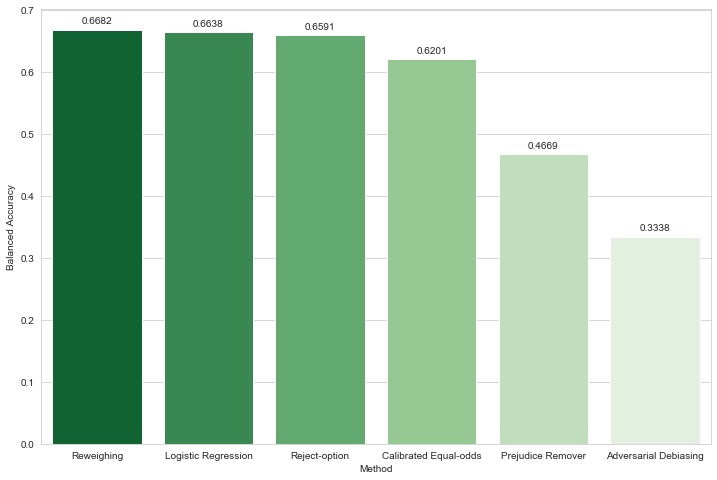

In [169]:
plot_results(x = 'Method', y = 'Result', data = bal_accs, 
    metricname = 'Balanced Accuracy', saveto = 'RES_BAL_ACC.png',
    order = bal_accs.sort_values('Result', ascending = False).Method)

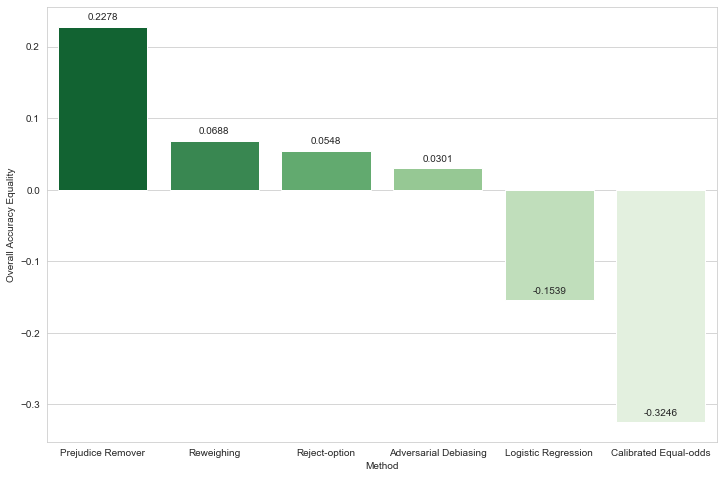

In [170]:
plot_results(x = 'Method', y = 'Result', data = acc_eqs, 
    metricname = 'Overall Accuracy Equality', saveto = 'RES_ACC_EQS.png',
    order = acc_eqs.sort_values('Result', ascending = False).Method)

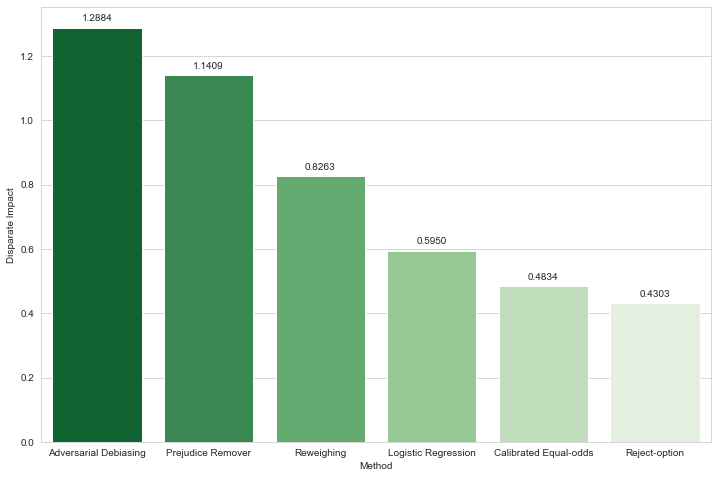

In [171]:
plot_results(x = 'Method', y = 'Result', data = disp_imps, 
    metricname = 'Disparate Impact', saveto = 'RES_DISP_IMPS.png',
    order = disp_imps.sort_values('Result', ascending = False).Method)

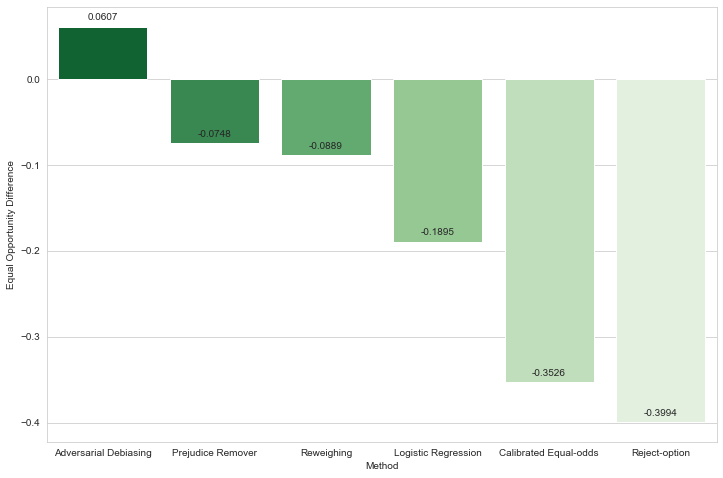

In [172]:
plot_results(x = 'Method', y = 'Result', data = eq_opps, 
    metricname = 'Equal Opportunity Difference', saveto = 'RES_EQ_OPPS.png',
    order = eq_opps.sort_values('Result', ascending = False).Method)

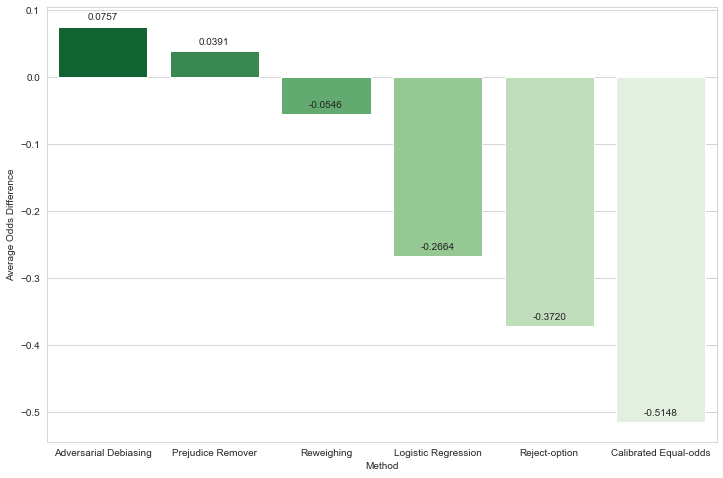

In [173]:
plot_results(x = 'Method', y = 'Result', data = avg_odds, 
    metricname = 'Average Odds Difference', saveto = 'RES_AVG_ODDS.png',
    order = avg_odds.sort_values('Result', ascending = False).Method)

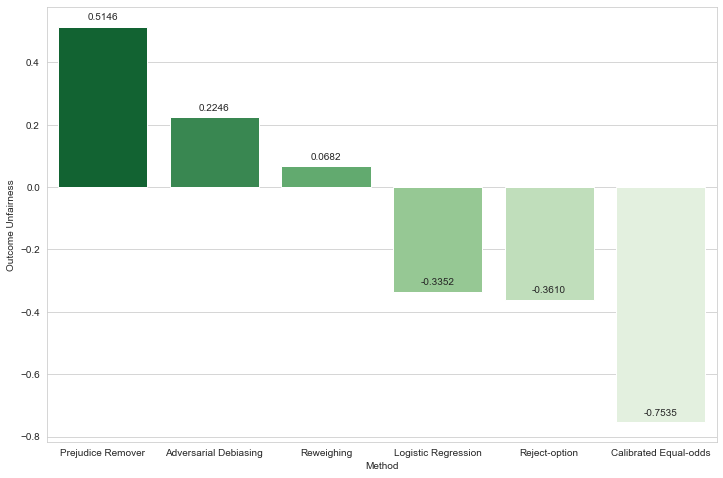

In [174]:
plot_results(x = 'Method', y = 'Result', data = out_unfs, 
    metricname = 'Outcome Unfairness', saveto = 'RES_OUT_UNFS.png',
    order = out_unfs.sort_values('Result', ascending = False).Method)

### Results across the classification thresholds

In [176]:
def plot_results_from_json(filenames, metricname, saveto, set_lims, xlimits, ylimits):
    plt.figure(figsize = (12, 8))
    sns.set_style('whitegrid')
    # palette = sns.color_palette('Set2', 6)
    palette = sns.color_palette('YlGn', 6)
    for i, filename in enumerate(filenames):
        with open(os.path.join(DATA, filename)) as file:
            metric_threshs = json.load(file)
            ax = sns.lineplot(x = class_thresh_arr, y = metric_threshs, color = palette[i])
    ax.axvline(best_class_thresh, color = 'k', linestyle = ':')
    ax.set_xlabel('Classification Thresholds', fontsize = 14, fontweight = 'bold')
    ax.set_ylabel(metricname, fontsize = 14, fontweight = 'bold')
    if set_lims == True:
        ax.set_xlim(xlimits)
        ax.set_ylim(ylimits)
    plt.legend(['Logisitic Regression', 'Reweighing', 'Adversarial Debiasing', \
        'Prejudice Remover', 'Reject-option Classification', 'Calibrated Equal-Odds'])
    plt.savefig(saveto, bbox_inches = 'tight')

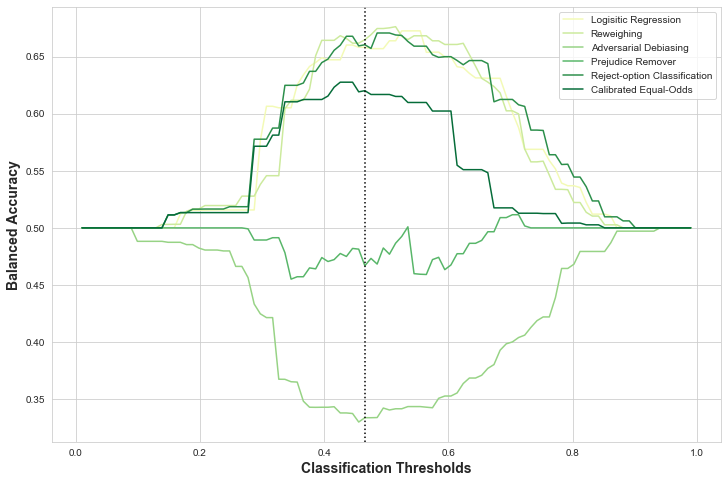

In [177]:
plot_results_from_json(filenames = ['LR_bal_acc_arr.json', 'RW_bal_acc_arr.json', 'AD_bal_acc_arr.json', \
    'PR_bal_acc_arr.json', 'ROC_bal_acc_arr.json', 'CEOD_bal_acc_arr.json'], 
    xlimits = (0.0, 1.0), ylimits = (0.0, 1.0), set_lims = False, 
    metricname = 'Balanced Accuracy', saveto = 'RES_balanced_accuracy.png')

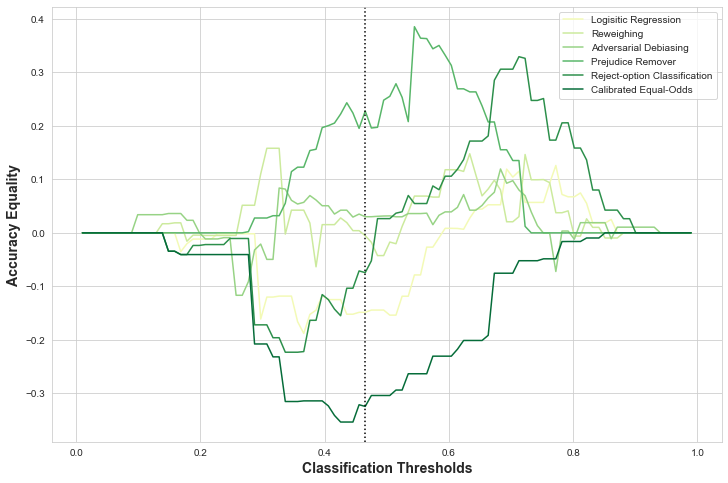

In [178]:
plot_results_from_json(filenames = ['LR_acc_equal_arr.json', 'RW_acc_equal_arr.json', 'AD_acc_equal_arr.json', 
    'PR_acc_equal_arr.json', 'ROC_acc_equal_arr.json', 'CEOD_acc_equal_arr.json'],
    xlimits = (0.0, 1.0), ylimits = (0.0, 1.0), set_lims = False,
    metricname = 'Accuracy Equality', saveto = 'RES_accuracy_equality.png')

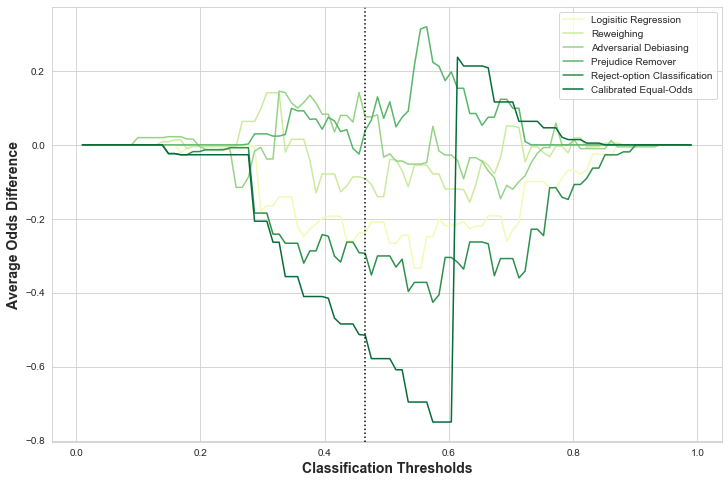

In [179]:
plot_results_from_json(filenames = ['LR_avg_odds_diff_arr.json', 'RW_avg_odds_diff_arr.json', 'AD_avg_odds_diff_arr.json', 
    'PR_avg_odds_diff_arr.json', 'ROC_avg_odds_diff_arr.json', 'CEOD_avg_odds_diff_arr.json'], 
    xlimits = (0.0, 1.0), ylimits = (0.0, 1.0), set_lims = False,
    metricname = 'Average Odds Difference', saveto = 'RES_average_odds.png')

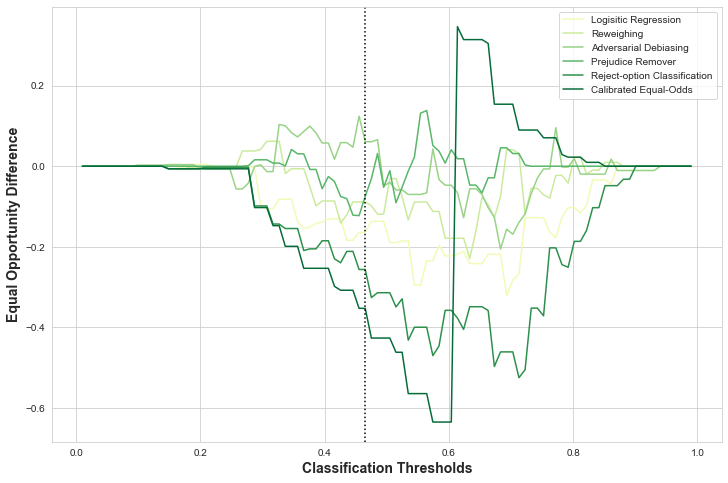

In [180]:
plot_results_from_json(filenames = ['LR_eq_opp_diff_arr.json', 'RW_eq_opp_diff_arr.json', 'AD_eq_opp_diff_arr.json', 
    'PR_eq_opp_diff_arr.json', 'ROC_eq_opp_diff_arr.json', 'CEOD_eq_opp_diff_arr.json'], 
    xlimits = (0.0, 1.0), ylimits = (0.0, 1.0), set_lims = False,
    metricname = 'Equal Opportunity Difference', saveto = 'RES_equal_opps.png')

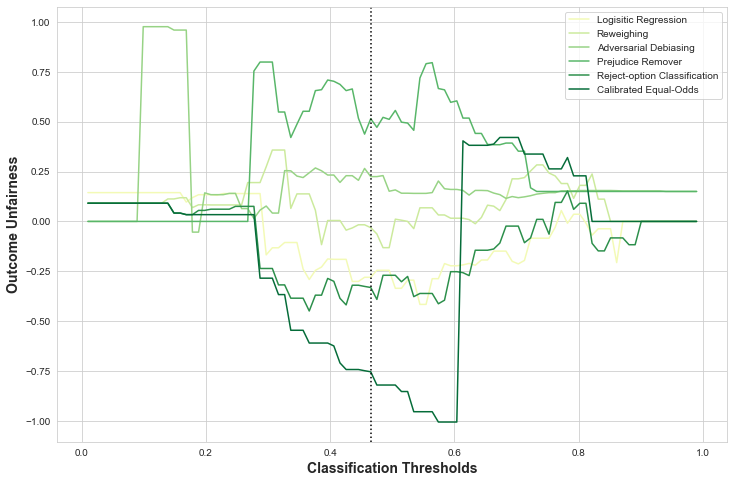

In [181]:
plot_results_from_json(filenames = ['LR_outcome_unfair_arr.json', 'RW_outcome_unfair_arr.json', 'AD_outcome_unfair_arr.json', 
    'PR_outcome_unfair_arr.json', 'ROC_outcome_unfair_arr.json', 'CEOD_outcome_unfair_arr.json'],
    xlimits = (0.0, 1.0), ylimits = (0.0, 1.0), set_lims = False,
    metricname = 'Outcome Unfairness', saveto = 'RES_outcome_unfair.png')

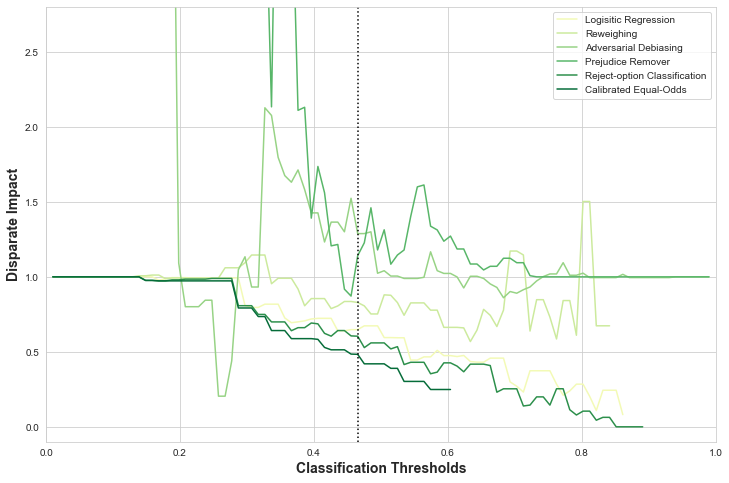

In [183]:
plot_results_from_json(filenames = ['LR_disp_imp_arr.json', 'RW_disp_imp_arr.json', 'AD_disp_imp_arr.json', 
    'PR_disp_imp_arr.json', 'ROC_disp_imp_arr.json', 'CEOD_disp_imp_arr.json'], 
    xlimits = (0.0, 1.0), ylimits = (-0.1, 2.8), set_lims = True,
    metricname = 'Disparate Impact', saveto = 'RES_disp_imp.png')

### Plotting using Plotly

In [184]:
PLOTLY = '/Users/megantennies/FYP/plotly figures'

In [192]:
def plot_plotly_graphs(metric, filenames, filepath):
    class_thresh_arr = np.linspace(0.01, 0.99, 100)
    magma = ['rgb(26, 14, 63)', 'rgb(76, 19, 108)', 'rgb(134, 34, 109)' ,'rgb(201, 51, 91)' ,'rgb(246, 99, 74)' ,'rgb(254, 173, 110)']
    grey = 'rgb(217, 217, 217)'
    fig = go.Figure()
    i = 0
    for (file, name) in zip(filenames['Files'], filenames['Names']):
        file_data = read_json(file)
        fig.add_trace(go.Scatter(x = class_thresh_arr, y = file_data, mode = 'lines', name = name, line = dict(color = greens[i], width = 2)))
        i += 1
    fig.add_vline(x = 0.4357, line_dash = 'dash', line_width = 2)
    fig.update_layout(xaxis_title = 'Classification thresholds', yaxis_title = metric,
        yaxis = dict(showgrid = True, linewidth = 2, showticklabels = True, ticks = 'outside', 
        tickfont = dict(size = 12, color = 'black')), 
        xaxis = dict(showgrid = True, linewidth = 2, showticklabels = True, ticks = 'outside', 
        tickfont = dict(size = 12, color = 'black')), showlegend = True, font_color = 'black')
    fig.write_html(os.path.join(PLOTLY, filepath))
    return fig

In [193]:
bal_acc_files = {'Files' : ['LR_bal_acc_arr.json', 'RW_bal_acc_arr.json', 'AD_bal_acc_arr.json', 
    'PR_bal_acc_arr.json', 'ROC_bal_acc_arr.json', 'CEOD_bal_acc_arr.json'], 
    'Names': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Predjudice Remover', 
    'Reject-option Classification', 'Calibrated Equalised-odds Difference']}
plot_plotly_graphs(metric = 'Balanced Accuracy', filenames = bal_acc_files, filepath = 'bal_acc_plotly.html')

In [194]:
acc_equal_files = {'Files' : ['LR_acc_equal_arr.json', 'RW_acc_equal_arr.json', 'AD_acc_equal_arr.json', 
    'PR_acc_equal_arr.json', 'ROC_acc_equal_arr.json', 'CEOD_acc_equal_arr.json'], 
    'Names': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Predjudice Remover', 
    'Reject-option Classification', 'Calibrated Equalised-odds Difference']}
plot_plotly_graphs(metric = 'Accuracy Equality', filenames = acc_equal_files, filepath = 'acc_eq_plotly.html')

In [195]:
disp_imp_files = {'Files' : ['LR_disp_imp_arr.json', 'RW_disp_imp_arr.json', 'AD_disp_imp_arr.json', 
    'PR_disp_imp_arr.json', 'ROC_disp_imp_arr.json', 'CEOD_disp_imp_arr.json'], 
    'Names': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Predjudice Remover', 
    'Reject-option Classification', 'Calibrated Equalised-odds Difference']}
plot_plotly_graphs(metric = 'Disparate Impact', filenames = disp_imp_files, filepath = 'disp_imp_plotly.html')

In [196]:
avg_odds_files = {'Files' : ['LR_avg_odds_diff_arr.json', 'RW_avg_odds_diff_arr.json', 'AD_avg_odds_diff_arr.json', 
    'PR_avg_odds_diff_arr.json', 'ROC_avg_odds_diff_arr.json', 'CEOD_avg_odds_diff_arr.json'], 
    'Names': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Predjudice Remover', 
    'Reject-option Classification', 'Calibrated Equalised-odds Difference']}
plot_plotly_graphs(metric = 'Average Odds Difference', filenames = avg_odds_files, filepath = 'avg_odds_plotly.html')

In [197]:
eq_opp_files = {'Files' : ['LR_eq_opp_diff_arr.json', 'RW_eq_opp_diff_arr.json', 'AD_eq_opp_diff_arr.json', 
    'PR_eq_opp_diff_arr.json', 'ROC_eq_opp_diff_arr.json', 'CEOD_eq_opp_diff_arr.json'], 
    'Names': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Predjudice Remover', 
    'Reject-option Classification', 'Calibrated Equalised-odds Difference']}
plot_plotly_graphs(metric = 'Equal Opportunity Difference', filenames = eq_opp_files, filepath = 'eq_opps_plotly.html')

In [198]:
out_unf_files = {'Files' : ['LR_outcome_unfair_arr.json', 'RW_outcome_unfair_arr.json', 'AD_outcome_unfair_arr.json', 
    'PR_outcome_unfair_arr.json', 'ROC_outcome_unfair_arr.json', 'CEOD_outcome_unfair_arr.json'], 
    'Names': ['Logistic Regression', 'Reweighing', 'Adversarial Debiasing', 'Predjudice Remover', 
    'Reject-option Classification', 'Calibrated Equalised-odds Difference']}
plot_plotly_graphs(metric = 'Outcome Unfairness', filenames = out_unf_files, filepath = 'out_unf_plotly.html')